# Intro

# Table of Contents



#  Project Initialization

In [1]:
# In V1_0_mass_geodesic.ipynb, Cell ID 33f07e1c
import os
import shutil
import sympy as sp
import nrpy.c_function as cfc
import nrpy.c_codegen as ccg
import nrpy.params as par
import nrpy.indexedexp as ixp
import nrpy.infrastructures.BHaH.BHaH_defines_h as Bdefines_h
import nrpy.infrastructures.BHaH.Makefile_helpers as Makefile
from nrpy.infrastructures.BHaH import cmdline_input_and_parfiles
import nrpy.helpers.generic as gh
import nrpy.infrastructures.BHaH.CodeParameters as CPs

project_name = "mass_integrator"
project_dir = os.path.join("project", project_name)
shutil.rmtree(project_dir, ignore_errors=True)

par.set_parval_from_str("Infrastructure", "BHaH")

# --- Physical Parameters ---
M_scale = par.CodeParameter("REAL", __name__, "M_scale", 1.0, commondata=True, add_to_parfile=True, add_to_set_CodeParameters_h=True)
a_spin = par.CodeParameter("REAL", __name__, "a_spin", 0.9, commondata=True, add_to_parfile=True, add_to_set_CodeParameters_h=True)

# --- Integration & Termination Parameters ---
t_max_integration = par.CodeParameter("REAL", __name__, "t_max_integration", 2000.0, commondata=True, add_to_parfile=True)
flatness_threshold = par.CodeParameter("REAL", __name__, "flatness_threshold", 1e-2, commondata=True, add_to_parfile=True)
r_escape = par.CodeParameter("REAL", __name__, "r_escape", 1500.0, commondata=True, add_to_parfile=True)
ut_max = par.CodeParameter("REAL", __name__, "ut_max", 1e3, commondata=True, add_to_parfile=True)

# --- Debugging & Validation Parameters ---
perform_conservation_check = par.CodeParameter("bool", __name__, "perform_conservation_check", True, commondata=True, add_to_parfile=True)
run_in_debug_mode = par.CodeParameter("bool", __name__, "run_in_debug_mode", True, commondata=True, add_to_parfile=True)

# --- Disk Parameters ---

disk_lambda_rest_at_r_min = par.CodeParameter("REAL", __name__, "disk_lambda_rest_at_r_min", 656.3, commondata=True, add_to_parfile=True)

disk_num_r= par.CodeParameter("int", __name__, "disk_num_r", 100, commondata=True, add_to_parfile=True)
disk_num_phi= par.CodeParameter("int", __name__, "disk_num_phi", 200, commondata=True, add_to_parfile=True)
disk_r_min = par.CodeParameter("REAL", __name__, "disk_r_min", 6.0, commondata=True, add_to_parfile=True)
disk_r_max = par.CodeParameter("REAL", __name__, "disk_r_max", 25.0, commondata=True, add_to_parfile=True)
snapshot_every_t = par.CodeParameter("REAL", __name__, "snapshot_every_t", 10.0, commondata=True, add_to_parfile=True)
t_final = par.CodeParameter("REAL", __name__, "t_final", 2000.0, commondata=True, add_to_parfile=True)
output_folder = par.CodeParameter("char[100]", __name__, "output_folder", "output", commondata=True, add_to_parfile=True)

<a id='symbolic_core'></a>
# Step 3: The Symbolic Core - Foundational Math

This section defines the pure mathematical logic of our problem using Python's `sympy` library. Each function in this section is a "blueprint" for a physical calculation. These functions take symbolic `sympy` objects as input and return new symbolic expressions as output. They have no knowledge of C code; they are concerned only with mathematics and will be called later to generate the "recipes" for our C code engines.

<a id='deriv_g4DD'></a>
### 3.a: Metric Tensor Derivatives

The first step in calculating the Christoffel symbols is to compute the partial derivatives of the metric tensor, $g_{\mu\nu}$. This function, `derivative_g4DD`, takes the symbolic 4x4 metric tensor `g4DD` and a list of the four coordinate symbols `xx` as input.

The function iterates through all components to symbolically calculate the partial derivative of each metric component with respect to each coordinate. The resulting quantity, which we can denote using comma notation as $g_{\mu\nu,\alpha}$, is defined as:

$$ g_{\mu\nu,\alpha} \equiv \frac{\partial g_{\mu\nu}}{\partial x^{\alpha}} $$

The nested `for` loops in the code directly correspond to the spacetime indices `μ, ν, α` in the physics equation. `sympy`'s built-in `sp.diff()` function is used to perform the symbolic differentiation, and the final result is returned as a rank-3 symbolic tensor.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.zerorank3(dimension)`**:
    *   **Source File**: `nrpy/indexedexp.py`
    *   **Description**: This function creates a symbolic rank-3 tensor (a Python list of lists of lists) of a specified dimension, with all elements initialized to the `sympy` integer 0. It is used here to create a container for the derivative results.

In [2]:
def derivative_g4DD(g4DD, xx):
    """Computes the symbolic first derivatives of the metric tensor."""
    g4DD_dD = ixp.zerorank3(dimension=4)
    for nu in range(4):
        for mu in range(4):
            for alpha in range(4):
                g4DD_dD[nu][mu][alpha] = sp.diff(g4DD[nu][mu], xx[alpha])
    return g4DD_dD

<a id='four_connections'></a>
### 3.b: Christoffel Symbol Calculation

This function implements the core formula for the Christoffel symbols of the second kind, $\Gamma^{\delta}_{\mu\nu}$. It takes the symbolic metric tensor `g4DD` ($g_{\mu\nu}$) and its derivatives `g4DD_dD` ($g_{\mu\nu,\alpha}$) as input. The calculation requires the inverse metric, $g^{\mu\nu}$, which is computed using another `nrpy` helper function.

The function then applies the well-known formula for the Christoffel symbols. Using the comma notation for partial derivatives, the formula is:

$$ \Gamma^{\delta}_{\mu\nu} = \frac{1}{2} g^{\delta\alpha} \left( g_{\nu\alpha,\mu} + g_{\mu\alpha,\nu} - g_{\mu\nu,\alpha} \right) $$

The Python `for` loops iterate over the spacetime indices `δ, μ, ν, α` to construct each component of the Christoffel symbol tensor. After the summation is complete, the `sp.trigsimp()` function is used to simplify the resulting expression. This trigonometric simplification is highly effective and much faster than a general `sp.simplify()` for the Kerr-Schild metric, which contains trigonometric functions of the coordinates.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.zerorank3(dimension)`**: Previously introduced. Used to initialize the Christoffel symbol tensor.
*   **`nrpy.indexedexp.symm_matrix_inverter4x4(g4DD)`**:
    *   **Source File**: `nrpy/indexedexp.py`
    *   **Description**: This function takes a symbolic 4x4 symmetric matrix and analytically computes its inverse. It is highly optimized for this specific task, returning both the inverse matrix ($g^{\mu\nu}$) and its determinant.

In [3]:
def four_connections(g4DD, g4DD_dD):
    """
    Computes and simplifies Christoffel symbols from the metric and its derivatives.
    
    This version uses sp.trigsimp() which is highly effective and much faster
    than sp.simplify() for the Kerr-Schild metric.
    """
    Gamma4UDD = ixp.zerorank3(dimension=4)
    g4UU, _ = ixp.symm_matrix_inverter4x4(g4DD)
    
    for mu in range(4):
        for nu in range(4):
            for delta in range(4):
                # Calculate the Christoffel symbol component using the standard formula
                for alpha in range(4):
                    Gamma4UDD[delta][mu][nu] += sp.Rational(1, 2) * g4UU[delta][alpha] * \
                        (g4DD_dD[nu][alpha][mu] + g4DD_dD[mu][alpha][nu] - g4DD_dD[mu][nu][alpha])
                
                # Use sp.trigsimp() to simplify the resulting expression.
                # This is the key to speeding up the symbolic calculation.
                Gamma4UDD[delta][mu][nu] = sp.trigsimp(Gamma4UDD[delta][mu][nu])

    return Gamma4UDD

<a id='geodesic_mom_rhs'></a>
### 3.c: Geodesic Momentum RHS

This function defines the symbolic right-hand side (RHS) for the evolution of the **reverse-time momentum**, $p^{\alpha}$. As established in the introduction, this is the second of our three first-order ODEs:
$$ \frac{dp^{\alpha}}{d\kappa} = -\Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} $$
The function `geodesic_mom_rhs` takes the symbolic Christoffel symbols $\Gamma^{\alpha}_{\mu\nu}$ as its input. It then defines the symbolic momentum vector `pU` using `sympy`'s `sp.symbols()` function. A key `nrpy` technique is used here: the symbols are created with names that are already valid C array syntax (e.g., `"y[4]"`). This "direct naming" simplifies the final C code generation by eliminating the need for string substitutions.

The core of this function constructs the symbolic expression for the RHS by performing the Einstein summation $-\Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu}$. A direct implementation would involve a double loop over both $\mu$ and $\nu$ from 0 to 3, resulting in $4 \times 4 = 16$ terms for each component of $\alpha$, which is computationally inefficient.

However, we can significantly optimize this calculation by exploiting symmetry. The term $p^{\mu} p^{\nu}$ is symmetric with respect to the interchange of the indices $\mu$ and $\nu$. The Christoffel symbols $\Gamma^{\alpha}_{\mu\nu}$ are also symmetric in their lower two indices. Therefore, the full sum can be split into diagonal ($\mu=\nu$) and off-diagonal ($\mu \neq \nu$) terms:
$$ \sum_{\mu,\nu} \Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} = \sum_{\mu=0}^{3} \Gamma^{\alpha}_{\mu\mu} (p^{\mu})^2 + \sum_{\mu \neq \nu} \Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} $$
The second sum over $\mu \neq \nu$ contains pairs of identical terms (e.g., the $\mu=1, \nu=2$ term is the same as the $\mu=2, \nu=1$ term). We can combine all such pairs by summing over only one of the cases (e.g., $\mu < \nu$) and multiplying by two:
$$ \sum_{\mu,\nu} \Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} = \sum_{\mu=0}^{3} \Gamma^{\alpha}_{\mu\mu} (p^{\mu})^2 + 2 \sum_{\mu < \nu} \Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} $$
The Python code implements this optimized version, ensuring that each component of the RHS is computed with the minimum number of floating point operations, leading to more efficient C code.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.zerorank1(dimension)`**:
    *   **Source File**: `nrpy/indexedexp.py`
    *   **Description**: Creates a symbolic rank-1 tensor (a Python list) of a specified dimension, with all elements initialized to the `sympy` integer 0. It is used here to create a container for the four components of the momentum RHS.

In [4]:
def geodesic_vel_rhs_massive():
    """
    Symbolic RHS for massive particle velocity ODE: du^a/dτ = -Γ^a_μν u^μ u^ν.
    u is the 4-velocity, y[4]...y[7].
    """
    Gamma4UDD = ixp.declarerank3("conn->Gamma4UDD",dimension= 4,sym="sym12")
    ut,ux,uy,uz = sp.symbols("y[4] y[5] y[6] y[7]", Real=True)
    uU = [ut,ux,uy,uz]
    geodesic_rhs = ixp.zerorank1(dimension=4)
    for alpha in range(4):
        for mu in range(4):
            geodesic_rhs[alpha] += Gamma4UDD[alpha][mu][mu] * uU[mu] * uU[mu]
            for nu in range(mu + 1, 4):
                geodesic_rhs[alpha] += 2 * Gamma4UDD[alpha][mu][nu] * uU[mu] * uU[nu]
        geodesic_rhs[alpha] = -geodesic_rhs[alpha]
    return geodesic_rhs


<a id='geodesic_pos_rhs'></a>
### 3.d: Geodesic Position RHS

This function defines the symbolic right-hand side (RHS) for the evolution of the position coordinates, $x^{\alpha}$. As derived in the introduction, this is the first of our three first-order ODEs:

$$ \frac{dx^{\alpha}}{d\kappa} = p^{\alpha} $$

The Python function `geodesic_pos_rhs` is straightforward. It defines the components of the reverse-time momentum vector, `pU`, using `sympy`'s `sp.symbols()` function with the "direct naming" convention (`y[4]`, `y[5]`, etc.). It then simply returns a list containing these momentum components. This list of four symbolic expressions will serve as the first four components of the complete 9-component RHS vector that our C code will solve.

In [5]:
def geodesic_pos_rhs_massive():
    """
    Symbolic RHS for position ODE: dx^a/dτ = u^a.
    u is the 4-velocity, y[4]...y[7].
    """
    ut,ux,uy,uz = sp.symbols("y[4] y[5] y[6] y[7]", Real=True)
    uU = [ut,ux,uy,uz]
    return uU

<a id='geodesic_mom0_calc'></a>
### 3.f: Symbolic Calculation of u^0

In [6]:
def ut_massive():
    """
    Symbolically derives u^t for a MASSIVE particle from the 4-velocity.
    The derivation comes from solving the timelike normalization condition g_μν u^μ u^ν = -1.
    """
    # The symbolic recipe will use the standard variable names u0, u1, etc.
    # The C-generating function will map y[4], y[5], etc. to these.
    u0,u1,u2,u3 = sp.symbols("u0 u1 u2 u3", Real=True)
    uU=[u0,u1,u2,u3]
    
    # The recipe uses the standard name "metric" for the struct.
    g4DD = ixp.declarerank2("metric->g", sym="sym01", dimension=4)

    # This is the quadratic equation for u^0, derived from g_μν u^μ u^ν = -1
    # g_00(u^0)^2 + 2g_0i u^0 u^i + g_ij u^i u^j = -1
    # We solve for u^0.
    sum_g0i_ui = sp.sympify(0)
    for i in range(1,4):
        sum_g0i_ui += g4DD[0][i]*uU[i]
        
    sum_gij_ui_uj = sp.sympify(0)
    for i in range(1,4):
        sum_gij_ui_uj += g4DD[i][i]*uU[i]*uU[i]
        for j in range(i+1,4):
            sum_gij_ui_uj += 2*g4DD[i][j]*uU[i]*uU[j]
            
    # The discriminant of the quadratic formula for u^0
    # CORRECTED: This now includes the "+1" term from g_μν u^μ u^ν = -1
    discriminant = sum_g0i_ui**2 - g4DD[0][0]*(sum_gij_ui_uj + 1)
    
    # We choose the positive root for a forward-in-time particle outside the horizon.
    # Note: Your choice of the minus sign was correct for the final expression.
    answer = (-sum_g0i_ui - sp.sqrt(discriminant)) / g4DD[0][0]
    return answer

# Symblic ut and uphi for Keplarian disk based on radius

In [7]:
def symbolic_ut_uphi_from_r():
    """
    Symbolically derives the fundamental orbital quantities u^t and u^phi for a 
    circular, equatorial, prograde orbit at a given radius r, using the final
    simplified analytical formulas.
    """
    # Define parameters as symbolic variables
    r, M, a = sp.symbols("r_initial M_scale a_spin", real=True)
    
    # Common denominator term from the analytical solution
    den_term = r**(3/4) * sp.sqrt(r**(3/2) - 3*M*r**(1/2) + 2*a*M**(1/2))
    
    # Final simplified formula for u^t
    ut = (r**(3/2) + a*M**(1/2)) / den_term
    
    # Final simplified formula for u^phi
    uphi = M**(1/2) / den_term
    
    # Return the two fundamental quantities
    return [ut, uphi]

# Markdown for conserved Energy

In [8]:
def symbolic_energy():
    """
    Computes the symbolic expression for conserved energy E = -p_t.
    E = -g_{t,mu} p^mu
    """
    # Define the 4-momentum components using the y[4]...y[7] convention
    pt, px, py, pz = sp.symbols("y[4] y[5] y[6] y[7]", real=True)
    pU = [pt, px, py, pz]
    
    # Define an abstract metric tensor to be filled by a C struct at runtime
    g4DD = ixp.declarerank2("metric->g", sym="sym01", dimension=4)
    
    # Calculate p_t = g_{t,mu} p^mu
    p_t = sp.sympify(0)
    for mu in range(4):
        p_t += g4DD[0][mu] * pU[mu]
        
    return -p_t


# Markdown for conserved L

In [9]:
def symbolic_L_components_cart():
    """
    Computes the symbolic expressions for the three components of angular momentum,
    correctly accounting for the symmetry of the metric tensor.
    """
    # Define coordinate and 4-momentum components
    t, x, y, z = sp.symbols("y[0] y[1] y[2] y[3]", real=True)
    pt, px, py, pz = sp.symbols("y[4] y[5] y[6] y[7]", real=True)
    pU = [pt, px, py, pz]
    
    # Define an abstract metric tensor
    g4DD = ixp.declarerank2("metric->g", sym="sym01", dimension=4)
    
    # --- THIS IS THE CORE FIX ---
    # Calculate covariant momentum components p_k = g_{k,mu} p^mu,
    # correctly exploiting the metric's symmetry g_mu,nu = g_nu,mu.
    p_down = ixp.zerorank1(dimension=4)
    for k in range(1, 4): # We only need p_x, p_y, p_z for L_i
        # Sum over mu
        for mu in range(4):
            # Use g4DD[k][mu] if k <= mu, otherwise use g4DD[mu][k]
            if k <= mu:
                p_down[k] += g4DD[k][mu] * pU[mu]
            else: # k > mu
                p_down[k] += g4DD[mu][k] * pU[mu]
            
    p_x, p_y, p_z = p_down[1], p_down[2], p_down[3]

    # Calculate angular momentum components 
    L_x = y*p_z - z*p_y
    L_y = z*p_x - x*p_z
    L_z = x*p_y - y*p_x
    
    return [L_x, L_y, L_z]

# Markdown for Carter Constant

In [10]:
# In file: V10_Python_to_C_via_NRPy.ipynb
# In the "Symbolic Recipes" cell (Final, Corrected symbolic_carter_constant_Q_final)

# symbolic_energy() and symbolic_L_components_cart() remain correct.

def symbolic_carter_constant_Q():
    """
    Computes the symbolic expression for the Carter Constant Q using a
    verified formula, robustly handling the axial singularity.
    """
    # Define all necessary symbolic variables
    t, x, y, z = sp.symbols("y[0] y[1] y[2] y[3]", real=True)
    pt, px, py, pz = sp.symbols("y[4] y[5] y[6] y[7]", real=True)
    pU = [pt, px, py, pz]
    a = sp.Symbol("a_spin", real=True)
    g4DD = ixp.declarerank2("metric->g", sym="sym01", dimension=4)

    # --- Step 1: Compute intermediate quantities E, Lz, and p_i ---
    E = symbolic_energy()
    _, _, Lz = symbolic_L_components_cart()
    
    p_down = ixp.zerorank1(dimension=4)
    for k in range(1, 4):
        for mu in range(4):
            if k <= mu: p_down[k] += g4DD[k][mu] * pU[mu]
            else: p_down[k] += g4DD[mu][k] * pU[mu]
    p_x, p_y, p_z = p_down[1], p_down[2], p_down[3]

    # --- Step 2: Compute geometric terms ---
    r_sq = x**2 + y**2 + z**2
    rho_sq = x**2 + y**2
    
    # --- Step 3: Compute p_theta^2 directly in Cartesian components ---
    # This avoids square roots and potential complex number issues in sympy.
    # p_theta^2 = r^2 * p_z^2 + cot^2(theta) * (x*p_x + y*p_y)^2 - 2*r*p_z*cot(theta)*(x*p_x+y*p_y)
    # where cot(theta) = z / rho
    
    # This term is (x*p_x + y*p_y)
    xpx_plus_ypy = x*p_x + y*p_y
    
    # This is p_theta^2, constructed to avoid dividing by rho before squaring.
    # It is equivalent to (z*xpx_plus_ypy/rho - rho*p_z)^2
    p_theta_sq = (z**2 * xpx_plus_ypy**2 / rho_sq) - (2 * z * p_z * xpx_plus_ypy) + (rho_sq * p_z**2)

    # --- Step 4: Assemble the final formula for Q ---
    # Q = p_theta^2 + cos^2(theta) * (-a^2*E^2 + L_z^2/sin^2(theta))
    # where cos^2(theta) = z^2/r^2 and sin^2(theta) = rho^2/r^2
    
    # This is the second term in the Q formula
    second_term = (z**2 / r_sq) * (-a**2 * E**2 + Lz**2 * (r_sq / rho_sq))
    
    Q_formula = p_theta_sq + second_term
    
    # --- Step 5: Handle the axial singularity ---
    # For motion on the z-axis (rho_sq -> 0), Lz=0 and p_theta=0, so Q=0.
    Q_final = sp.Piecewise(
        (0, rho_sq < 1e-12),
        (Q_formula, True)
    )
    
    return Q_final

print("Final symbolic recipes for conserved quantities defined (Carter Constant re-derived).")

Final symbolic recipes for conserved quantities defined (Carter Constant re-derived).


<a id='spacetime_definition'></a>
# Step 4: Spacetime Definition in Kerr-Schild Coordinates

This section defines the specific spacetime geometry in which the geodesics will be integrated. Instead of defining separate metrics for Schwarzschild (non-rotating) and Kerr (rotating) black holes, we use a single, powerful coordinate system: **Cartesian Kerr-Schild coordinates**. This system has a major advantage over more common coordinate systems like Boyer-Lindquist: it is regular everywhere, including at the event horizon. This means the metric components and their derivatives do not diverge, allowing the numerical integrator to trace a photon's path seamlessly across the horizon without encountering coordinate singularities.

The Kerr-Schild metric $g_{\mu\nu}$ is constructed by adding a correction term to the flat Minkowski metric $\eta_{\mu\nu}$:
$$ g_{\mu\nu} = \eta_{\mu\nu} + 2H l_\mu l_\nu $$
where $\eta_{\mu\nu}$ is the Minkowski metric `diag(-1, 1, 1, 1)`, $l_\mu$ is a special null vector, and $H$ is a scalar function that depends on the black hole's mass $M$ and spin $a$.

The function `define_kerr_metric_Cartesian_Kerr_Schild()` implements this formula symbolically. It defines the coordinates `(t, x, y, z)`, the mass `M`, and the spin `a` as `sympy` symbols. It then constructs the components of the null vector $l_\mu$ and the scalar function $H$. Finally, it assembles the full metric tensor $g_{\mu\nu}$.

A key feature of this formulation is that if the spin parameter `a` is set to zero, the metric automatically and exactly reduces to the Schwarzschild metric in Cartesian coordinates. This allows a single set of symbolic expressions and a single set of C functions to handle both spacetimes, with the specific behavior controlled by the runtime value of the `a_spin` parameter.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.zerorank1(dimension)`**: Previously introduced. Used to initialize the null vector $l_\mu$.
*   **`nrpy.indexedexp.zerorank2(dimension)`**: Previously introduced. Used to initialize the metric tensor $g_{\mu\nu}$.

In [11]:
def define_kerr_metric_Cartesian_Kerr_Schild():
    """
    Defines the Kerr metric tensor in Cartesian Kerr-Schild coordinates.

    This function is the new, unified source for both Kerr (a != 0) and
    Schwarzschild (a = 0) spacetimes. The coordinates are (t, x, y, z).
    
    Returns:
        A tuple (g4DD, xx), where g4DD is the symbolic 4x4 metric tensor
        and xx is the list of symbolic coordinate variables.
    """
    # Define the symbolic coordinates using the 'y[i]' convention for the integrator
    t, x, y, z = sp.symbols("y[0] y[1] y[2] y[3]", real=True)
    xx = [t, x, y, z]

    # Access the symbolic versions of the mass and spin parameters
    M = M_scale.symbol
    a = a_spin.symbol

    # Define intermediate quantities
    r2 = x**2 + y**2 + z**2
    r = sp.sqrt(r2)
    
    # Define the Kerr-Schild null vector l_μ
    l_down = ixp.zerorank1(dimension=4)
    l_down[0] = 1
    l_down[1] = (r*x + a*y) / (r2 + a**2)
    l_down[2] = (r*y - a*x) / (r2 + a**2)
    l_down[3] = z/r

    # Define the scalar function H
    H = (M * r**3) / (r**4 + a**2 * z**2)

    # The Kerr-Schild metric is g_μν = η_μν + 2H * l_μ * l_ν
    # where η_μν is the Minkowski metric diag(-1, 1, 1, 1)
    g4DD = ixp.zerorank2(dimension=4)
    for mu in range(4):
        for nu in range(4):
            eta_mu_nu = 0
            if mu == nu:
                eta_mu_nu = 1
            if mu == 0 and nu == 0:
                eta_mu_nu = -1
            
            g4DD[mu][nu] = eta_mu_nu + 2 * H * l_down[mu] * l_down[nu]
            
    return g4DD, xx

# Markdown for Schwarzschild

In [12]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In the NEW CELL after define_kerr_metric_Cartesian_Kerr_Schild

def define_schwarzschild_metric_cartesian():
    """
    Defines the Schwarzschild metric tensor directly in Cartesian coordinates.
    
    This version uses the standard textbook formula and ensures all components
    are sympy objects to prevent C-generation errors.
    
    Returns:
        A tuple (g4DD, xx), where g4DD is the symbolic 4x4 metric tensor
        and xx is the list of symbolic coordinate variables.
    """
    # Define Cartesian coordinates
    t, x, y, z = sp.symbols("y[0] y[1] y[2] y[3]", real=True)
    xx = [t, x, y, z]

    # Access the symbolic mass parameter
    M = M_scale.symbol

    # Define r in terms of Cartesian coordinates
    r = sp.sqrt(x**2 + y**2 + z**2)

    # Define the Cartesian Schwarzschild metric components directly
    g4DD = ixp.zerorank2(dimension=4)
    
    # g_tt
    g4DD[0][0] = -(1 - 2*M/r)
    
    # Spatial components g_ij = δ_ij + (2M/r) * (x_i * x_j / r^2)
    x_i = [x, y, z]
    for i in range(3):
        for j in range(3):
            # --- CORRECTED: Use sp.sympify() for the kronecker delta ---
            delta_ij = sp.sympify(0)
            if i == j:
                delta_ij = sp.sympify(1)
            
            # The indices for g4DD are off by 1 from the spatial indices
            g4DD[i+1][j+1] = delta_ij + (2*M/r) * (x_i[i] * x_i[j] / (r**2))

    # --- CORRECTED: Ensure time-space components are sympy objects ---
    g4DD[0][1] = g4DD[1][0] = sp.sympify(0)
    g4DD[0][2] = g4DD[2][0] = sp.sympify(0)
    g4DD[0][3] = g4DD[3][0] = sp.sympify(0)
            
    return g4DD, xx

<a id='symbolic_execution'></a>
# Step 5: Symbolic Workflow Execution

This cell acts as the central hub for the symbolic portion of our project. In the preceding cells, we *defined* a series of Python functions that perform individual mathematical tasks. Here, we *execute* those functions in the correct sequence to generate all the final symbolic expressions that will serve as "recipes" for our C code generators.

This "symbolic-first" approach is a core `nrpy` principle and offers significant advantages:
1.  **Efficiency**: The complex symbolic calculations, such as inverting the metric tensor and deriving the Christoffel symbols, are performed **only once** when this notebook is run. The results are stored in global Python variables, preventing redundant and time-consuming recalculations. This is especially important for the Kerr metric, whose Christoffel symbols can take several minutes to compute.
2.  **Modularity**: This workflow creates a clean separation between the *specific solution* for a metric (e.g., the explicit formulas for the Kerr-Schild Christoffels) and the *generic form* of the equations of motion (which are valid for any metric).

This cell produces two key sets of symbolic expressions that are stored in global variables for later use:
*   **`Gamma4UDD_kerr`**: The explicit symbolic formulas for the Christoffel symbols of the unified Kerr-Schild metric.
*   **`all_rhs_expressions`**: A Python list containing the 9 symbolic expressions for the right-hand-sides of our generic ODE system. To achieve this generality, we create a symbolic **placeholder** for the Christoffel symbols using `ixp.declarerank3("conn->Gamma4UDD", ...)`. This placeholder is passed to `geodesic_mom_rhs()` to construct the geodesic equation in its abstract form. This elegant technique embeds the final C variable name (`conn->Gamma4UDD...`) directly into the symbolic expression, which dramatically simplifies the C code generation step for the `calculate_ode_rhs()` engine.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.declarerank3(name, dimension)`**: Previously introduced. Used here to create a symbolic placeholder for the Christoffel symbols that will be passed to the generic RHS engine.

In [13]:
# In V1_0_mass_geodesic.ipynb, Cell ID 5fbfe0b5
# --- 1. Define the Kerr-Schild metric and get its derivatives ---
print(" -> Computing Kerr-Schild metric and Christoffel symbols...")
g4DD_kerr, xx_kerr = define_kerr_metric_Cartesian_Kerr_Schild()
g4DD_dD_kerr = derivative_g4DD(g4DD_kerr, xx_kerr)
Gamma4UDD_kerr = four_connections(g4DD_kerr, g4DD_dD_kerr)
print("    ... Done.")

# --- 2. Define the Standard Schwarzschild metric in Cartesian and get its derivatives ---
print(" -> Computing Standard Schwarzschild (Cartesian) metric and Christoffel symbols...")
g4DD_schw_cart, xx_schw_cart = define_schwarzschild_metric_cartesian()
g4DD_dD_schw_cart = derivative_g4DD(g4DD_schw_cart, xx_schw_cart)
Gamma4UDD_schw_cart = four_connections(g4DD_schw_cart, g4DD_dD_schw_cart)
print("    ... Done.")

# --- NEW: Generate GENERIC symbolic RHS expressions for MASSIVE geodesics ---
rhs_pos_massive = geodesic_pos_rhs_massive() 
rhs_vel_massive = geodesic_vel_rhs_massive()
# The state vector is now 8 components (no L)
all_rhs_expressions_massive = rhs_pos_massive + rhs_vel_massive

# --- NEW: Generate symbolic recipe for u^t from 3-velocity ---
ut_expr_from_vel = ut_massive()
ut_expr, uphi_expr = symbolic_ut_uphi_from_r()
print(" -> Defined generic global symbolic variables for massive particle ODEs.")

# --- 4. Generate symbolic recipes for conserved quantities ---
print(" -> Generating symbolic recipes for conserved quantities...")
E_expr = symbolic_energy()
Lx_expr, Ly_expr, Lz_expr = symbolic_L_components_cart()
Q_expr_kerr = symbolic_carter_constant_Q()
Q_expr_schw = Lx_expr**2 + Ly_expr**2 + Lz_expr**2
list_of_expressions_kerr = [E_expr, Lx_expr, Ly_expr, Lz_expr, Q_expr_kerr]
list_of_expressions_schw = [E_expr, Lx_expr, Ly_expr, Lz_expr, Q_expr_schw]
print("    ... Conservation recipes generated.")

 -> Computing Kerr-Schild metric and Christoffel symbols...
    ... Done.
 -> Computing Standard Schwarzschild (Cartesian) metric and Christoffel symbols...
    ... Done.
 -> Defined generic global symbolic variables for massive particle ODEs.
 -> Generating symbolic recipes for conserved quantities...
    ... Conservation recipes generated.


<a id='generate_c_engines'></a>
# Step 6: C Code Generation - Physics "Engines" and "Workers"

This section marks our transition from pure symbolic mathematics to C code generation. The Python functions defined here are "meta-functions": their job is not to perform calculations themselves, but to **generate the C code** that will perform the calculations in the final compiled program.

We distinguish between two types of generated functions:
*   **Workers**: These are specialized functions that implement the physics for a *specific metric*. For example, `con_kerr_schild()` is a worker that only knows how to compute Christoffel symbols for the Kerr-Schild metric.
*   **Engines**: These are generic functions that implement physics equations valid for *any metric*. For example, `calculate_ode_rhs()` is an engine that can compute the geodesic equations for any metric, as long as the Christoffel symbols are provided to it.

This design pattern allows for maximum code reuse and extensibility.

# Schwarzschild Metric

In [14]:
def g4DD_schwarzschild_cartesian():
    """
    Generates and registers the C function to compute the Schwarzschild
    metric components in standard Cartesian coordinates.
    """
    print(" -> Generating C worker function: g4DD_schwarzschild_cartesian()...")
    
    # Use the globally defined g4DD_schw_cart from the symbolic execution step
    list_of_g4DD_syms = []
    for i in range(4):
        for j in range(i, 4):
            list_of_g4DD_syms.append(g4DD_schw_cart[i][j])

    list_of_g4DD_C_vars = []
    for i in range(4):
        for j in range(i, 4):
            list_of_g4DD_C_vars.append(f"metric->g{i}{j}")

    includes = ["BHaH_defines.h"]
    desc = r"""@brief Computes the 10 unique components of the Schwarzschild metric in Cartesian coords."""
    name = "g4DD_schwarzschild_cartesian"
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const double y[4], metric_struct *restrict metric"
   
    body = ccg.c_codegen(list_of_g4DD_syms, list_of_g4DD_C_vars, enable_cse=True)

    cfc.register_CFunction(
        includes=includes, desc=desc, name=name, params=params, body=body,
        include_CodeParameters_h=True
    )
    print("    ... g4DD_schwarzschild_cartesian() registration complete.")


<a id='g4DD_kerr_schild_engine'></a>
### 6.a: `g4DD_kerr_schild()` Worker

This Python function generates the C **worker** function `g4DD_kerr_schild()`, whose only job is to compute the 10 unique components of the Kerr-Schild metric tensor, $g_{\mu\nu}$, at a given point in spacetime.

The generation process is as follows:
1.  **Access Symbolic Recipe:** It accesses the global `g4DD_kerr` variable, which holds the symbolic `sympy` expression for the Kerr-Schild metric tensor, generated in Step 5.
2.  **Define C Assignment:** It creates two Python lists: one containing the 10 unique symbolic metric expressions (`list_of_g4DD_syms`) and another containing the corresponding C variable names for the members of the `metric_struct` (e.g., `metric->g00`, `metric->g01`, etc.) in `list_of_g4DD_C_vars`.
3.  **Generate C Code:** It passes these two lists to `nrpy.c_codegen.c_codegen`. This powerful `nrpy` function converts the symbolic math into highly optimized C code, including performing Common Subexpression Elimination (CSE).
4.  **Register C Function:** Finally, it bundles the generated C code with its metadata (description, parameters, etc.) and registers the complete function with `nrpy.c_function.register_CFunction`. Crucially, it sets `include_CodeParameters_h=True` to automatically handle access to both the `M_scale` and `a_spin` parameters via the "Triple-Lock" system.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_codegen.c_codegen(sympy_expressions, C_variable_names, **kwargs)`**:
    *   **Source File**: `nrpy/c_codegen.py`
    *   **Description**: The core symbolic-to-C translation engine. It takes a list of `sympy` expressions and a corresponding list of C variable names and generates optimized C code to perform the assignments.
    *   **Key Inputs**:
        *   `sympy_expressions`: A Python list of symbolic expressions to be converted to C code.
        *   `C_variable_names`: A Python list of strings for the C variables that will store the results.
    *   **Key Keyword Arguments (`kwargs`)**:
        *   `enable_cse=True`: Enables Common Subexpression Elimination, which finds repeated mathematical operations, assigns them to temporary variables, and reuses those variables to reduce redundant calculations. This is essential for performance.

*   **`nrpy.c_function.register_CFunction(name, params, body, **kwargs)`**:
    *   **Source File**: `nrpy/c_function.py`
    *   **Description**: This is the workhorse for defining a C function. It takes all necessary metadata and stores it in a global dictionary, `cfc.CFunction_dict`. The final build system uses this dictionary to write all the `.c` source files.
    *   **Key Inputs**:
        *   `name`: The name of the C function.
        *   `params`: A string defining the function's parameters (e.g., `"const double y[4], ..."`).
        *   `body`: A string containing the C code for the function's body.
    *   **Key Keyword Arguments (`kwargs`)**:
        *   `include_CodeParameters_h=True`: Enables the "Triple-Lock" system for this function, automatically including `set_CodeParameters.h` at the top of the function body.

In [15]:
def g4DD_kerr_schild():
    """
    Generates and registers the C function to compute the Kerr-Schild
    metric components in Cartesian coordinates. This is the new unified worker.
    """
    print(" -> Generating C worker function: g4DD_kerr_schild()...")
    
    # We use the globally defined g4DD_kerr from the symbolic execution step
    list_of_g4DD_syms = []
    for i in range(4):
        for j in range(i, 4):
            list_of_g4DD_syms.append(g4DD_kerr[i][j])

    list_of_g4DD_C_vars = []
    for i in range(4):
        for j in range(i, 4):
            list_of_g4DD_C_vars.append(f"metric->g{i}{j}")

    includes = ["BHaH_defines.h"]
    desc = r"""@brief Computes the 10 unique components of the Kerr metric in Cartesian Kerr-Schild coords."""
    name = "g4DD_kerr_schild"
    # The state vector y now contains (t, x, y, z)
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const double y[4], metric_struct *restrict metric"
   
    body = ccg.c_codegen(list_of_g4DD_syms, list_of_g4DD_C_vars, enable_cse=True)

    cfc.register_CFunction(
        includes=includes, desc=desc, name=name, params=params, body=body,
        include_CodeParameters_h=True
    )
    print("    ... g4DD_kerr_schild() registration complete.")


<a id='con_kerr_schild_engine'></a>
### 6.b: `con_kerr_schild()` Worker

This function is structured identically to the `g4DD_kerr_schild` worker. It generates the C **worker** function `con_kerr_schild()`, whose only job is to compute the 40 unique Christoffel symbols for the unified Kerr-Schild metric.

The process is as follows:
1.  **Access Symbolic Recipe:** It accesses the pre-computed symbolic Christoffel formulas from the global `Gamma4UDD_kerr` variable, which was generated in Step 5.
2.  **Define C Assignment:** It creates a list of the 40 unique symbolic expressions and a corresponding list of the C variable names for the members of the `connection_struct` (e.g., `conn->Gamma4UDD012`).
3.  **Generate C Code:** It uses `nrpy.c_codegen.c_codegen` to convert these highly complex symbolic expressions into optimized C code. The Common Subexpression Elimination (CSE) performed by `c_codegen` is absolutely essential here, as it reduces what would be thousands of floating-point operations into a much more manageable and efficient set of calculations.
4.  **Register C Function:** Like the other workers, it registers the function using `nrpy.c_function.register_CFunction` and sets `include_CodeParameters_h=True` to handle its dependency on both `M_scale` and `a_spin`.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.indexedexp.declarerank3(name, dimension)`**: Previously introduced. Used here to programmatically generate the C variable names for the Christoffel symbols that will be stored in the `connection_struct`.
*   **`nrpy.c_codegen.c_codegen(...)`**: Previously introduced.
*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [16]:
def con_kerr_schild():
    """
    Generates and registers the C function to compute the Kerr-Schild Christoffel symbols.
    This is the new unified worker.
    """
    print(" -> Generating C worker function: con_kerr_schild()...")
    
    # We use the globally defined Gamma4UDD_kerr from the symbolic execution step
    list_of_Gamma_syms = []
    for i in range(4):
        for j in range(4):
            for k in range(j, 4):
                list_of_Gamma_syms.append(Gamma4UDD_kerr[i][j][k])

    conn_Gamma4UDD = ixp.declarerank3("conn->Gamma4UDD", dimension=4)
    list_of_Gamma_C_vars = []
    for i in range(4):
        for j in range(4):
            for k in range(j, 4):
                list_of_Gamma_C_vars.append(str(conn_Gamma4UDD[i][j][k]))

    includes = ["BHaH_defines.h"]
    desc = r"""@brief Computes the 40 unique Christoffel symbols for the Kerr metric in Kerr-Schild coords."""
    name = "con_kerr_schild"
    # The state vector y now contains (t, x, y, z)
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const double y[4], connection_struct *restrict conn"

    body = ccg.c_codegen(list_of_Gamma_syms, list_of_Gamma_C_vars, enable_cse=True)
    
    cfc.register_CFunction(
        includes=includes, desc=desc, name=name, params=params, body=body,
        include_CodeParameters_h=True
    )
    print("    ... con_kerr_schild() registration complete.")

# Con Schwarzschild

In [17]:
def con_schwarzschild_cartesian():
    """
    Generates and registers the C function to compute the Schwarzschild Christoffel symbols
    in standard Cartesian coordinates.
    """
    print(" -> Generating C worker function: con_schwarzschild_cartesian()...")
    
    # Use the globally defined Gamma4UDD_schw_cart
    list_of_Gamma_syms = []
    for i in range(4):
        for j in range(4):
            for k in range(j, 4):
                list_of_Gamma_syms.append(Gamma4UDD_schw_cart[i][j][k])

    conn_Gamma4UDD = ixp.declarerank3("conn->Gamma4UDD", dimension=4)
    list_of_Gamma_C_vars = []
    for i in range(4):
        for j in range(4):
            for k in range(j, 4):
                list_of_Gamma_C_vars.append(str(conn_Gamma4UDD[i][j][k]))

    includes = ["BHaH_defines.h"]
    desc = r"""@brief Computes the unique Christoffel symbols for the Schwarzschild metric in Cartesian coords."""
    name = "con_schwarzschild_cartesian"
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const double y[4], connection_struct *restrict conn"

    body = ccg.c_codegen(list_of_Gamma_syms, list_of_Gamma_C_vars, enable_cse=True)

    cfc.register_CFunction(
        includes=includes, desc=desc, name=name, params=params, body=body,
        include_CodeParameters_h=True
    )
    print("    ... con_schwarzschild_cartesian() registration complete.")


<a id='calculate_ode_rhs_engine'></a>
### 6.d: `calculate_ode_rhs()` Engine

This function generates the core "engine" of our ODE solver: the C function `calculate_ode_rhs()`. Its single responsibility is to calculate the right-hand sides for our entire system of 9 ODEs. It is completely generic and has no knowledge of any specific metric; it only knows how to compute the geodesic equations given a set of Christoffel symbols and the spatial metric components.

The generation process is straightforward:
1.  **Access Generic Recipe:** It accesses the global `all_rhs_expressions` list. This list contains the generic symbolic form of the ODEs for position, momentum, and proper length that we derived in Step 5.
2.  **Generate C Code:** It passes this list directly to `nrpy.c_codegen.c_codegen`. The symbols used to build `all_rhs_expressions` were already created with their final C syntax (e.g., `y[5]` for the momentum, `conn->Gamma4UDD...` for the Christoffel placeholder, and `metric->g...` for the metric placeholder). Therefore, no further symbolic manipulation is needed. `nrpy` simply translates the expressions into optimized C code.
3.  **Register C Function:** The generated C code body is bundled with its metadata and registered. This function does not require the `include_CodeParameters_h` flag because it is physically generic and receives all necessary information through its arguments.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_codegen.c_codegen(...)`**: Previously introduced.
*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [18]:
def calculate_ode_rhs_massive():
    """
    Generates the C engine to calculate the RHS of the 8 massive particle ODEs.
    """
    includes = ["BHaH_defines.h"]
    desc = r"""@brief Calculates the right-hand sides (RHS) of the 8 massive particle geodesic ODEs.
    
    This is a generic engine that implements the geodesic equation using pre-computed
    Christoffel symbols from the connection_struct.
    
    @param[in]  y         The 8-component state vector [t, x, y, z, u^t, u^x, u^y, u^z].
    @param[in]  conn      A pointer to the connection_struct holding the Christoffel symbols.
    @param[out] rhs_out   A pointer to the 8-component output array for the RHS results."""
    name = "calculate_ode_rhs_massive"
    params = "const double y[8], const connection_struct *restrict conn, double rhs_out[8]"
    
    rhs_output_vars = [f"rhs_out[{i}]" for i in range(8)]
    body = ccg.c_codegen(all_rhs_expressions_massive, rhs_output_vars)

    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        name=name,
        params=params,
        body=body
    )

# Markdown for check_conservation

In [19]:
def check_conservation_massive():
    """
    Generates the C function `check_conservation_massive`.
    """
    print(" -> Generating C engine: check_conservation_massive()...")

    output_vars_kerr = ["*E", "*Lx", "*Ly", "*Lz", "*Q"]
    output_vars_schw = ["*E", "*Lx", "*Ly", "*Lz", "*Q"]

    body_C_code_kerr = ccg.c_codegen(list_of_expressions_kerr, output_vars_kerr, enable_cse=True, include_braces=False)
    body_C_code_schw = ccg.c_codegen(list_of_expressions_schw, output_vars_schw, enable_cse=True, include_braces=False)

    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]
    desc = r"""@brief Computes conserved quantities (E, L_i, Q/L^2) for a given massive particle state vector."""
    name = "check_conservation_massive"
    params = """const commondata_struct *restrict commondata,
        const params_struct *restrict params,
        const metric_params *restrict metric_params_in,
        const double y[8], 
        double *E, double *Lx, double *Ly, double *Lz, double *Q"""
        
    body = r"""
    // Unpack parameters from commondata struct that are needed symbolically
    const REAL a_spin = commondata->a_spin;

    metric_struct* metric = (metric_struct*)malloc(sizeof(metric_struct));
    g4DD_metric(commondata, params, metric_params_in, y, metric);

    if (metric_params_in->type == Kerr) {
        """ + body_C_code_kerr + r"""
    } else { // Both Schwarzschild types are now Cartesian
        """ + body_C_code_schw + r"""
    }
    
    free(metric);
    """

    cfc.register_CFunction(
        includes=includes, desc=desc, cfunc_type="void",
        name=name, params=params, body=body
    )
    print(f"    ... {name}() registration complete.")

<a id='generate_c_orchestrators'></a>
# Step 7: C Code Generation - Orchestrators and Dispatchers

With the low-level "engine" and "worker" functions defined in the previous step, we now generate the higher-level C functions that manage the simulation. These functions are responsible for dispatching to the correct worker based on runtime parameters and for orchestrating the overall program flow.

*   **Dispatchers** are functions that contain a `switch` statement to select the correct "worker" function based on the chosen metric (e.g., `Schwarzschild` vs. `Kerr`).
*   **Orchestrators** are functions that execute a sequence of calls to other engines, workers, and dispatchers to perform a complex task, like setting up initial conditions or running the main integration loop.

<a id='g4DD_metric_dispatcher'></a>
### 7.a: `g4DD_metric()` Dispatcher

This Python function generates the C function `g4DD_metric()`, which serves as a high-level **dispatcher.** Its role is to select and call the correct worker function to compute the components of the metric tensor, $g_{\mu\nu}$.

The generated C code uses a `switch` statement that reads the `metric->type` member of the `metric_params` struct. In this project, both the Schwarzschild and Kerr spacetimes are handled by the unified `g4DD_kerr_schild()` worker function. The dispatcher calls this single worker, and the specific metric returned by the worker depends on the runtime value of the `a_spin` parameter (if `a_spin` is 0, the Schwarzschild metric is computed).

This modular approach cleanly separates the control flow (deciding *which* metric to use) from the physics implementation (the worker functions that know *how* to compute a specific metric). This makes the project easy to extend with new spacetimes in the future by adding new cases to the `switch` statement and new worker functions.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced. Used to register the manually written C code for the dispatcher function.

In [20]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In cell [65702cb7]

def g4DD_metric():
    """
    Generates and registers the C function g4DD_metric(), which serves as a
    dispatcher to call the appropriate metric-specific worker function.
    """
    print(" -> Generating C dispatcher function: g4DD_metric()...")
    
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]
    desc = r"""@brief Dispatcher to compute the 4-metric g_munu for the chosen metric."""
    name = "g4DD_metric"
    # The signature is now coordinate-aware, but the y vector is always Cartesian here.
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const metric_params *restrict metric, const double y[8], metric_struct *restrict metric_out"
    
    body = r"""
    // The state vector y_pos contains only the position coordinates.
    const double y_pos[4] = {y[0], y[1], y[2], y[3]};

    // This switch statement chooses which "worker" function to call
    // based on the metric type provided.
    switch(metric->type) {
        case Schwarzschild:
        case Kerr:
            // For Kerr or Schwarzschild in KS coords, call the unified Kerr-Schild C function.
            g4DD_kerr_schild(commondata, params, y_pos, metric_out);
            break;
        // <-- MODIFIED: Call the new Cartesian worker
        case Schwarzschild_Standard:
            g4DD_schwarzschild_cartesian(commondata, params, y_pos, metric_out);
            break;
        case Numerical:
            printf("Error: Numerical metric not supported yet.\n");
            exit(1);
            break;
        default:
            printf("Error: MetricType %d not supported in g4DD_metric() yet.\n", metric->type);
            exit(1);
            break;
    }
"""
    
    cfc.register_CFunction(includes=includes, desc=desc, name=name, params=params, body=body)
    print("    ... g4DD_metric() registration complete.")

<a id='connections_dispatcher'></a>
### 7.b: `connections()` Dispatcher

This Python function generates the C function `connections()`, which acts as a second **dispatcher.** Its sole responsibility is to select and call the correct metric-specific worker function (like `con_kerr_schild()`) to compute the Christoffel symbols.

Like the `g4DD_metric()` dispatcher, the generated C code uses a `switch` statement based on the `metric->type`. It dispatches the call to the appropriate specialized worker, which in this case is the unified `con_kerr_schild()` function for both Kerr and Schwarzschild spacetimes. This design is highly extensible: adding a new metric simply requires writing a new worker function for its Christoffel symbols and adding a new `case` to this `switch` statement.

This function demonstrates how `nrpy` allows for the seamless integration of developer-written control flow with the automatically generated worker functions.

### `nrpy` Functions Used in this Cell:

*   **`nrpy.c_function.register_CFunction(...)`**: Previously introduced.

In [21]:
# In file: V11_0_Python_to_C_via_NRPy.ipynb
# In cell [b92b7851]

def connections():
    """
    Generates and registers the C dispatcher for Christoffel symbols.
    """
    print(" -> Generating C dispatcher: connections()...")

    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "stdio.h", "stdlib.h"]
    desc = r"""@brief Dispatcher to compute Christoffel symbols for the chosen metric."""
    
    name = "connections"
    cfunc_type = "void" 
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const metric_params *restrict metric, const double y[8], connection_struct *restrict conn"

    body = r"""
    // The state vector y_pos contains only the position coordinates.
    const double y_pos[4] = {y[0], y[1], y[2], y[3]};

    // This switch statement chooses which "worker" function to call
    // based on the metric type provided.
    switch(metric->type) {
        case Schwarzschild:
        case Kerr:
            con_kerr_schild(commondata, params, y_pos, conn);
            break;
        // <-- MODIFIED: Call the new Cartesian worker
        case Schwarzschild_Standard:
            con_schwarzschild_cartesian(commondata, params, y_pos, conn);
            break;
        case Numerical:
            printf("Error: Numerical metric not supported yet.\n");
            exit(1);
            break;
        default:
            printf("Error: MetricType %d not supported yet.\n", metric->type);
            exit(1);
            break;
    }
"""

    cfc.register_CFunction(
        includes=includes, desc=desc, cfunc_type=cfunc_type,
        name=name, params=params, body=body
    )
    print("    ... connections() registration complete.")

# Calculate ut and uphi for the disk

In [22]:
def calculate_ut_uphi_from_r():
    """
    Generates a C helper function to compute u^t and u^phi from a radius.
    """
    includes = ["BHaH_defines.h"]
    desc = r"""@brief Computes u^t and u^phi for a circular orbit at a given radius."""
    name = "calculate_ut_uphi_from_r"

    params = "const double r_initial, const commondata_struct *restrict commondata, const params_struct *restrict params, double *ut, double *uphi"
    
    ut_expr, uphi_expr = symbolic_ut_uphi_from_r()
    
    body = ccg.c_codegen(
        [ut_expr, uphi_expr],
        ["*ut", "*uphi"],
        enable_cse=True
    )
    
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        name=name,
        params=params,
        body=body,
        include_CodeParameters_h=True
    )


# set_initial_conditions_massive

In [23]:
def set_initial_conditions_massive():
    """
    Generates the C engine to set the full initial 8-component state vector
    from a user-provided initial 4-position and spatial 4-velocity.
    """
    includes = ["BHaH_defines.h"]
    desc = r"""@brief Sets the initial 8-component state vector for a massive particle.
    
    This function takes an initial 4-position (t,x,y,z) and the spatial components
    of the 4-velocity (u^x, u^y, u^z) and computes the time component u^t by
    enforcing the timelike normalization condition g_μν u^μ u^ν = -1.
    
    @param[in]  initial_state  Pointer to a struct with initial pos and spatial 4-velocity.
    @param[in]  metric         Pointer to a metric_struct with values at the initial position.
    @param[out] y_out          The 8-component initial state vector to be populated."""
    name = "set_initial_conditions_massive"
    params = "const particle_initial_state_t *restrict initial_state, const metric_struct *restrict metric, double y_out[8]"

    # Preamble to bridge the symbolic recipe and the C function's variables.
    # The symbolic recipe 'ut_massive' uses symbols u1, u2, u3.
    # This preamble creates C variables with those names.
    preamble = f"""
    // Unpack the spatial 4-velocity from the initial_state struct into local
    // variables u1, u2, u3 to match the symbolic recipe.
    const double u1 = initial_state->u_spatial[0];
    const double u2 = initial_state->u_spatial[1];
    const double u3 = initial_state->u_spatial[2];
    """
    
    # Generate C code for u^t from the generic recipe.
    # nrpy will map the symbols (u1, metric->g00, etc.) to the C variables.
    ut_C_code = ccg.c_codegen(ut_massive(), "const double ut", include_braces=False, enable_cse=True)
    
    body = f"""
        // Set initial position part of the state vector y[0]...y[3]
        y_out[0] = initial_state->pos[0]; // t
        y_out[1] = initial_state->pos[1]; // x
        y_out[2] = initial_state->pos[2]; // y
        y_out[3] = initial_state->pos[3]; // z
        
        // --- Start of Preamble ---
        {preamble}
        // --- End of Preamble ---
        
        // Calculate u^t using the pre-generated C code.
        {ut_C_code}
        
        // Set the full 4-velocity in the state vector y[4]...y[7]
        y_out[4] = ut;
        y_out[5] = initial_state->u_spatial[0]; // u^x
        y_out[6] = initial_state->u_spatial[1]; // u^y
        y_out[7] = initial_state->u_spatial[2]; // u^z
    """
    
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        name=name,
        params=params,
        body=body
    )

# Disk Initial Conditions

In [24]:
def generate_disk_initial_conditions():
    """
    Generates a C function that programmatically creates the initial conditions
    for a Keplerian disk.
    """
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]
    desc = r"""@brief Generates the complete y[8] initial state for all particles in a Keplerian disk."""
    cfunc_type = "int"
    name = "generate_disk_initial_conditions"

    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, double *restrict y_initial_states"
    

    body = r"""
    int particle_count = 0;
    const double dr = (commondata->disk_num_r > 1) ? (commondata->disk_r_max - commondata->disk_r_min) / (commondata->disk_num_r - 1) : 0;

    for (int i = 0; i < commondata->disk_num_r; i++) {
        const double r = commondata->disk_r_min + i * dr;
        
        const int num_phi_at_r = (commondata->disk_num_phi > 1) ? (int)(commondata->disk_num_phi * (r / commondata->disk_r_max)) : 1;
        if (num_phi_at_r == 0) continue;
        const double dphi = 2.0 * M_PI / num_phi_at_r;
        
        double ut_at_r, uphi_at_r;
        // The call is now valid because 'params' is available in this function's scope.
        calculate_ut_uphi_from_r(r, commondata, params, &ut_at_r, &uphi_at_r);

        for (int j = 0; j < num_phi_at_r; j++) {
            const double phi = j * dphi;
            const double cos_phi = cos(phi);
            const double sin_phi = sin(phi);
            
            double *y = &y_initial_states[particle_count * 8];
            
            y[0] = 0.0;
            y[1] = r * cos_phi;
            y[2] = r * sin_phi;
            y[3] = 0.0;
            
            y[4] = ut_at_r;
            y[5] = -(r * sin_phi) * uphi_at_r;
            y[6] =  (r * cos_phi) * uphi_at_r;
            y[7] = 0.0;
            
            particle_count++;
        }
    }
    return particle_count;
    """
    
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        cfunc_type=cfunc_type,
        name=name,
        params=params,
        body=body
    )

<a id='gsl_wrapper'></a>
### 7.d: The GSL Wrapper Function (Redo)

In [25]:
def ode_gsl_wrapper_massive():
    """
    Generates the C function that acts as a bridge between the GSL ODE
    solver and our project-specific physics functions.
    """
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "gsl/gsl_errno.h"]
    desc = r"""@brief GSL wrapper for the massive particle geodesic ODEs.
    
    This function matches the signature required by the GSL ODE solver. It unpacks
    the gsl_params carrier struct and calls the dispatchers for the metric and
    Christoffel symbols, before finally calling the RHS engine.
    
    @param[in]  t      The current value of the independent variable (proper time τ). Unused.
    @param[in]  y      The current 8-component state vector.
    @param[in]  params A generic void pointer to our gsl_params carrier struct.
    @param[out] f      A pointer to the 8-component output array where GSL expects the RHS results."""
    cfunc_type = "int"
    name = "ode_gsl_wrapper_massive"
    params = "double t, const double y[8], double f[8], void *params"
    
    body = r"""
        (void)t; // Proper time 't' is not explicitly used in the RHS expressions.
        
        // Unpack the carrier struct to access simulation parameters and metric choice.
        gsl_params *gsl_parameters = (gsl_params *)params;
        
        // Declare structs to hold metric and connection values.
        metric_struct g4DD;
        connection_struct conn;
        
        // Call dispatchers to compute the metric and Christoffel symbols at the current position y.
        // Note: The y array is 8D, but these functions only need the first 4 position components.
        g4DD_metric(gsl_parameters->commondata, gsl_parameters->params, gsl_parameters->metric, y, &g4DD);
        connections(gsl_parameters->commondata, gsl_parameters->params, gsl_parameters->metric, y, &conn);
        
        // Call the engine to compute the RHS of the ODEs.
        calculate_ode_rhs_massive(y, &conn, f);
        
        return GSL_SUCCESS;
    """
    
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        cfunc_type=cfunc_type,
        name=name, 
        params=params,
        body=body
    )

# Run Mass integrator production

In [26]:
def run_mass_integrator_production():
    """
    Generates the C orchestrator for the production run.
    
    UPDATED to correctly use the stored full 4-velocity u^mu during the 
    evolution loop, fixing critical logic errors from the previous version.
    """
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "<math.h>", "<sys/stat.h>"]
    desc = r"""@brief Orchestrates the full production run for the mass integrator."""
    name = "run_mass_integrator_production"
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const metric_params *restrict metric"
    
    body = r"""
    // Step 1: Generate the initial positions and velocities as a flat y[8] array
    const int max_particles = commondata->disk_num_r * commondata->disk_num_phi;
    double *y_initial_states = (double *)malloc(sizeof(double) * 8 * max_particles);
    const int num_particles = generate_disk_initial_conditions(commondata, params, y_initial_states);
    printf("Generated %d particles for the Keplerian disk.\n", num_particles);

    // Step 2: Create and populate our primary data structure, an array of mass_particle_state_t
    mass_particle_state_t *particle_states = (mass_particle_state_t *)malloc(sizeof(mass_particle_state_t) * num_particles);
    for (int i=0; i<num_particles; i++) {
        double *y_start = &y_initial_states[i*8];
        particle_states[i].id = i;
        particle_states[i].pos[0] = y_start[1]; // x
        particle_states[i].pos[1] = y_start[2]; // y
        particle_states[i].pos[2] = y_start[3]; // z
        
        // Store the full initial 4-velocity
        particle_states[i].u[0] = y_start[4]; // u^t
        particle_states[i].u[1] = y_start[5]; // u^x
        particle_states[i].u[2] = y_start[6]; // u^y
        particle_states[i].u[3] = y_start[7]; // u^z
        
        const double r = sqrt(y_start[1]*y_start[1] + y_start[2]*y_start[2]);
        particle_states[i].lambda_rest = commondata->disk_lambda_rest_at_r_min * pow(r / commondata->disk_r_min, 0.75);
        particle_states[i].j_intrinsic = (float)pow(r / commondata->disk_r_min, -3.0);
    }
    free(y_initial_states); 

    // Step 3: Create the output directory
    mkdir(commondata->output_folder, 0755);

    // Step 4: Main Time Evolution and Snapshotting Loop
    int snapshot_count = 0;
    for (double current_t = 0; current_t <= commondata->t_final; current_t += commondata->snapshot_every_t) {
        char filename[200];
        snprintf(filename, 200, "%s/mass_blueprint_t_%04d.bin", commondata->output_folder, snapshot_count);
        printf("Saving snapshot: %s (t=%.2f)\n", filename, current_t);
        
        FILE *fp_out = fopen(filename, "wb");
        if (fp_out == NULL) { exit(1); }
        
        int active_particles = 0;
        for(int i=0; i<num_particles; i++) {
            if (!isnan(particle_states[i].pos[0])) active_particles++;
        }
        fwrite(&active_particles, sizeof(int), 1, fp_out);
        for (int i=0; i<num_particles; i++) {
            if (!isnan(particle_states[i].pos[0])) {
                fwrite(&particle_states[i], sizeof(mass_particle_state_t), 1, fp_out);
            }
        }
        fclose(fp_out);
        snapshot_count++;

        if (current_t >= commondata->t_final) break;

        // Evolve all particles for one snapshot interval
        const double t_next_snapshot = current_t + commondata->snapshot_every_t;
        #pragma omp parallel for
        for (int i = 0; i < num_particles; i++) {
            if (isnan(particle_states[i].pos[0])) continue;

            // CORRECTED LOGIC:
            // Construct the y[8] state vector for the integrator directly
            // from the stored particle state.
            double y_particle[8];
            y_particle[0] = current_t;
            y_particle[1] = particle_states[i].pos[0];
            y_particle[2] = particle_states[i].pos[1];
            y_particle[3] = particle_states[i].pos[2];
            
            y_particle[4] = particle_states[i].u[0]; // Use stored u^t
            y_particle[5] = particle_states[i].u[1]; // Use stored u^x
            y_particle[6] = particle_states[i].u[2]; // Use stored u^y
            y_particle[7] = particle_states[i].u[3]; // Use stored u^z

            int status = integrate_single_particle(commondata, params, metric, y_particle[0], t_next_snapshot, y_particle);
            
            if (status != 0) {
                particle_states[i].pos[0] = NAN; // Mark particle as terminated
            } else {
                // CORRECTED LOGIC:
                // Update the stored state from the integrator's result.
                particle_states[i].pos[0] = y_particle[1];
                particle_states[i].pos[1] = y_particle[2];
                particle_states[i].pos[2] = y_particle[3];
                
                particle_states[i].u[0] = y_particle[4]; // Update stored u^t
                particle_states[i].u[1] = y_particle[5]; // Update stored u^x
                particle_states[i].u[2] = y_particle[6]; // Update stored u^y
                particle_states[i].u[3] = y_particle[7]; // Update stored u^z
            }
        }
    }
    free(particle_states);
    """
    cfc.register_CFunction(includes=includes, desc=desc, name=name, params=params, body=body)


###  The Main Integration 

In [27]:
def main_mass_integrator():
    """
    Generates the main() C function, which orchestrates the entire simulation.
    """
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]
    desc = r"""@brief Main entry point for the massive particle geodesic integrator."""
    cfunc_type = "int"
    name = "main"
    params = "int argc, const char *argv[]"
    
    body = r"""
    // Step 1: Initialize structs and parameters
    commondata_struct commondata;
    params_struct params;
    metric_params metric;
    
    commondata_struct_set_to_default(&commondata);
    cmdline_input_and_parfile_parser(&commondata, argc, argv);
    
    metric.type = (commondata.a_spin == 0.0) ? Schwarzschild : Kerr;

    // Step 2: Read particle initial conditions from file
    FILE *fp_in = fopen("particle_initial_conditions.txt", "r");
    if (fp_in == NULL) {
        fprintf(stderr, "Error: Could not open particle_initial_conditions.txt\n");
        return 1;
    }

    int num_particles = 0;
    char line[256];
    while (fgets(line, sizeof(line), fp_in)) {
        if (line[0] != '#') num_particles++;
    }
    rewind(fp_in);

    particle_initial_state_t *initial_states = (particle_initial_state_t *)malloc(sizeof(particle_initial_state_t) * num_particles);
    mass_blueprint_data_t *results_buffer = (mass_blueprint_data_t *)malloc(sizeof(mass_blueprint_data_t) * num_particles);

    printf("Reading %d particle initial states from file...\n", num_particles);
    for (int i = 0; i < num_particles; ) {
        if (fgets(line, sizeof(line), fp_in) && line[0] != '#') {
            sscanf(line, "%d %lf %lf %lf %lf %lf %lf", 
                   &initial_states[i].id, 
                   &initial_states[i].pos[0], &initial_states[i].pos[1], &initial_states[i].pos[2],
                   &initial_states[i].vel[0], &initial_states[i].vel[1], &initial_states[i].vel[2]);
            i++;
        }
    }
    fclose(fp_in);

    // Step 3: Main parallel loop over particles
    printf("Starting integration for %d particles...\n", num_particles);
    #pragma omp parallel for
    for (int i = 0; i < num_particles; i++) {
        metric_struct metric; // Use the standard name 'metric'
        double y_start[8], y_final[8];
        
        // Set initial position part of the state vector first.
        y_start[0] = 0.0;
        y_start[1] = initial_states[i].pos[0];
        y_start[2] = initial_states[i].pos[1];
        y_start[3] = initial_states[i].pos[2];

        // Compute metric at the initial position, passing the partially filled y_start.
        g4DD_metric(&commondata, &params, &metric, y_start, &metric);
        
        // Now compute the rest of the initial state (the 4-velocity).
        set_initial_conditions_massive(&initial_states[i], &metric, y_start);
        
        if (commondata.perform_conservation_check) {
            double E_i, Lx_i, Ly_i, Lz_i, Q_i;
            check_conservation_massive(&commondata, &params, &metric, y_start, &E_i, &Lx_i, &Ly_i, &Lz_i, &Q_i);
        }

        integrate_single_particle(&commondata, &params, &metric, y_start, y_final);
        
        results_buffer[i].particle_id = initial_states[i].id;
        results_buffer[i].time = y_final[0];
        for(int j=0; j<8; j++) results_buffer[i].y_state[j] = y_final[j];
    }

    // Step 4: Write results to binary file and clean up
    printf("Integration complete. Writing %d results to mass_blueprint.bin\n", num_particles);
    FILE *fp_out = fopen("mass_blueprint.bin", "wb");
    fwrite(results_buffer, sizeof(mass_blueprint_data_t), num_particles, fp_out);
    fclose(fp_out);

    free(initial_states);
    free(results_buffer);
    
    printf("Run finished successfully.\n");
    return 0;
    """
    
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        cfunc_type=cfunc_type,
        name=name,
        params=params,
        body=body
    )

# Main integration code

In [28]:
def integrate_single_particle():
    """
    Generates the main C integration loop for a single massive particle.
    This high-performance "production" version uses the GSL driver to ensure
    the state is returned at the exact requested snapshot times.
    """
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "gsl/gsl_errno.h", "gsl/gsl_odeiv2.h", "<math.h>"]
    desc = r"""@brief Integrates a single massive particle path between two times.
    
    This function uses the GSL driver, which internally uses an adaptive
    step-size algorithm (RKF45) to evolve the particle's state vector y_in_out
    from t_start to t_end, returning the state at the precise t_end.
    
    @param[in]      commondata  Pointer to commondata struct.
    @param[in]      params      Pointer to params_struct.
    @param[in]      metric      Pointer to metric_params struct.
    @param[in]      t_start     The starting proper time (τ) for the integration.
    @param[in]      t_end       The ending proper time (τ) for the integration.
    @param[in,out]  y_in_out    The 8-component state vector. Input is the state at t_start, output is the state at t_end.
    
    @return 0 on success, 1 on GSL failure.
    """
    cfunc_type = "int"
    name = "integrate_single_particle"
    params = """const commondata_struct *restrict commondata,
    const params_struct *restrict params,
    const metric_params *restrict metric,
    const double t_start, const double t_end,
    double y_in_out[8]"""

    body = r"""
    // Define the GSL ODE system
    gsl_params gsl_parameters = {commondata, params, metric};
    gsl_odeiv2_system sys = {ode_gsl_wrapper_massive, NULL, 8, &gsl_parameters};
    
    // Set up the GSL driver
    gsl_odeiv2_driver *d = gsl_odeiv2_driver_alloc_y_new(
        &sys, gsl_odeiv2_step_rkf45, 1e-6, 1e-11, 1e-11);
    
    double t = t_start;
    
    // The driver will take internal steps to reach t_end precisely.
    int status = gsl_odeiv2_driver_apply(d, &t, t_end, y_in_out);

    if (status != GSL_SUCCESS) {
        // Don't print an error here, as the orchestrator will check the status.
        // Just free memory and return the failure code.
        gsl_odeiv2_driver_free(d);
        return 1; // Return failure code
    }

    // Robustness check after the step
    const double r_sq = y_in_out[1]*y_in_out[1] + y_in_out[2]*y_in_out[2] + y_in_out[3]*y_in_out[3];
    const double r_horizon = commondata->M_scale * (1.0 + sqrt(1.0 - commondata->a_spin*commondata->a_spin));

    if (r_sq < r_horizon*r_horizon || r_sq > r_escape*r_escape || fabs(y_in_out[4]) > ut_max) {
        gsl_odeiv2_driver_free(d);
        return 1; // Return failure code
    }

    gsl_odeiv2_driver_free(d);
    return 0; // Return success code
    """
    
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        cfunc_type=cfunc_type,
        name=name,
        params=params,
        body=body, 
        include_CodeParameters_h=True
    )

# Bebugging integration (for single masslike particle)

In [29]:
def integrate_single_particle_DEBUG():
    """
    Generates a DEBUG version of the integrator that writes the full trajectory
    of a single massive particle to a text file for validation.
    """
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "gsl/gsl_errno.h", "gsl/gsl_odeiv2.h"]
    desc = r"""@brief DEBUG integrator for a single massive particle.
    
    This function integrates the path of a single particle and writes the full
    8-component state vector at each step to 'massive_particle_path.txt'.
    It also prints progress to the console and checks for termination conditions.
    
    @param[in]  commondata  Pointer to the commondata_struct.
    @param[in]  params      Pointer to the params_struct.
    @param[in]  metric      Pointer to the metric_params struct.
    @param[in]  start_y     The 8-component initial state vector.
    @param[out] final_y_state The 8-component final state vector upon termination."""
    cfunc_type = "void"
    name = "integrate_single_particle_DEBUG"
    params = """const commondata_struct *restrict commondata,
    const params_struct *restrict params,
    const metric_params *restrict metric,
    const double start_y[8],
    double final_y_state[8]"""

    body = r"""
    // GSL Setup
    const gsl_odeiv2_step_type * T = gsl_odeiv2_step_rkf45;
    gsl_odeiv2_step * step = gsl_odeiv2_step_alloc(T, 8);
    gsl_odeiv2_control * control = gsl_odeiv2_control_y_new(1e-12, 1e-12);
    gsl_odeiv2_evolve * evol = gsl_odeiv2_evolve_alloc(8);
    gsl_params gsl_parameters = {commondata, params, metric};
    gsl_odeiv2_system sys = {ode_gsl_wrapper_massive, NULL, 8, &gsl_parameters};

    double y_c[8];
    double t = 0.0, dt = 0.01; // t is proper time τ
    for (int j = 0; j < 8; j++) { y_c[j] = start_y[j]; }

    // Setup output file
    FILE *fp = fopen("massive_particle_path.txt", "w");
    if (fp == NULL) { 
        fprintf(stderr, "Error: Could not open massive_particle_path.txt for writing.\n");
        exit(1); 
    }
    fprintf(fp, "# ProperTime_tau\tCoordTime_t\tx\ty\tz\tu^t\tu^x\tu^y\tu^z\n");

    printf("Starting debug trace for single massive particle...\n");
    printf("Step | Proper Time (τ) | Coord Time (t) |      x     |      y     |      z     |      u^t   \n");
    printf("-------------------------------------------------------------------------------------------\n");

    // Main Integration Loop
    for (int i = 0; i < 500000; i++) {
        int status = gsl_odeiv2_evolve_apply(evol, control, step, &sys, &t, 1e10, &dt, y_c);
        
        // Write full state to file
        fprintf(fp, "%.6e\t%.6e\t%.6e\t%.6e\t%.6e\t%.6e\t%.6e\t%.6e\t%.6e\n", 
                t, y_c[0], y_c[1], y_c[2], y_c[3], y_c[4], y_c[5], y_c[6], y_c[7]);

        if (i % 500 == 0) {
            printf("%4d | %15.4e | %14.4f | %10.4f | %10.4f | %10.4f | %10.4f\n",
                   i, t, y_c[0], y_c[1], y_c[2], y_c[3], y_c[4]);
        }

        const double r_sq = y_c[1]*y_c[1] + y_c[2]*y_c[2] + y_c[3]*y_c[3];
        // Event horizon radius for a Kerr black hole
        const double r_horizon = commondata->M_scale * (1.0 + sqrt(1.0 - commondata->a_spin*commondata->a_spin));

        // Termination Conditions
        if (status != GSL_SUCCESS) { printf("Termination: GSL ERROR (status = %d)\n", status); break; }
        if (r_sq < r_horizon*r_horizon) { printf("Termination: Fell below event horizon (r=%.2f)\n", sqrt(r_sq)); break; }
        if (r_sq > r_escape*r_escape) { printf("Termination: Escaped to r > %.1f\n", r_escape); break; }
        if (fabs(y_c[4]) > ut_max) { printf("Termination: Runaway u^t > %.1e\n", ut_max); break; }
        if (fabs(y_c[0]) > t_max_integration) { printf("Termination: Exceeded max integration time t > %.1f\n", t_max_integration); break; }
    }

    // Copy final state to output and clean up
    for(int j=0; j<8; j++) { final_y_state[j] = y_c[j]; }
    fclose(fp);
    gsl_odeiv2_evolve_free(evol);
    gsl_odeiv2_control_free(control);
    gsl_odeiv2_step_free(step);
    """
    
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        cfunc_type=cfunc_type,
        name=name,
        params=params,
        body=body, 
        include_CodeParameters_h=True
    )

# Main

In [30]:
def main():
    """
    Generates the main() C function, which orchestrates the entire simulation.
    
    UPDATED to use the correct `mass_particle_state_t` struct and to fix an
    array-size mismatch in the debug execution path.
    """
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]
    desc = r"""@brief Main entry point for the massive particle geodesic integrator."""
    cfunc_type = "int"
    name = "main"
    params = "int argc, const char *argv[]"
    
    body = r"""
    // Step 1: Initialize structs and parameters
    commondata_struct commondata;
    params_struct params;
    metric_params metric;
    
    commondata_struct_set_to_default(&commondata);
    cmdline_input_and_parfile_parser(&commondata, argc, argv);
    
    metric.type = (commondata.a_spin == 0.0) ? Schwarzschild : Kerr;

    // Step 2: Check the run mode and execute the appropriate logic
    if (commondata.run_in_debug_mode) {
        /***********************************/
        /*** SINGLE-PARTICLE DEBUG MODE ***/
        /***********************************/
        particle_initial_state_t initial_state;
        initial_state.id = 0;

        const char *filename = "particle_debug_initial_conditions.txt";
        FILE *fp_in = fopen(filename, "r");
        if (fp_in == NULL) {
            printf("File '%s' not found. Creating it with default values.\n", filename);
            fp_in = fopen(filename, "w");
            if (fp_in == NULL) { fprintf(stderr, "Error: Could not create '%s'.\n", filename); return 1; }
            fprintf(fp_in, "# Format: t_initial pos_x pos_y pos_z u_x u_y u_z\n");
            fprintf(fp_in, "# u_i are the spatial components of the 4-velocity (dx/dτ).\n");
            fprintf(fp_in, "0.0 10.0  0.0  0.0   0.0  0.363232  0.0\n");
            fclose(fp_in);
            fp_in = fopen(filename, "r");
            if (fp_in == NULL) { fprintf(stderr, "Error: Could not re-open '%s'.\n", filename); return 1; }
        }

        char line[256];
        while (fgets(line, sizeof(line), fp_in)) {
            if (line[0] != '#') {
                sscanf(line, "%lf %lf %lf %lf %lf %lf %lf", 
                       &initial_state.pos[0], &initial_state.pos[1], &initial_state.pos[2], &initial_state.pos[3],
                       &initial_state.u_spatial[0], &initial_state.u_spatial[1], &initial_state.u_spatial[2]);
                break; 
            }
        }
        fclose(fp_in);

        printf("--- Single Particle Debug Run ---\n");
        printf("Using Initial Conditions from '%s':\n", filename);
        printf("  pos = (t=%.4f, x=%.4f, y=%.4f, z=%.4f)\n", initial_state.pos[0], initial_state.pos[1], initial_state.pos[2], initial_state.pos[3]);
        printf("  u_spatial = (%.4f, %.4f, %.4f)\n", initial_state.u_spatial[0], initial_state.u_spatial[1], initial_state.u_spatial[2]);

        metric_struct g4DD;
        double y_start[8], y_final[8];
        
        // CORRECTED: The g4DD_metric function expects the 8-component state vector y[8],
        // but it only uses the first 4 position components. We construct a temporary
        // y_pos array for this call.
        double y_pos_for_metric[8];
        y_pos_for_metric[0] = initial_state.pos[0];
        y_pos_for_metric[1] = initial_state.pos[1];
        y_pos_for_metric[2] = initial_state.pos[2];
        y_pos_for_metric[3] = initial_state.pos[3];
        
        g4DD_metric(&commondata, &params, &metric, y_pos_for_metric, &g4DD);
        
        set_initial_conditions_massive(&initial_state, &g4DD, y_start);

        printf("\nInitial State Vector (y_start):\n");
        printf("  t=%.2f, x=%.2f, y=%.2f, z=%.2f\n", y_start[0], y_start[1], y_start[2], y_start[3]);
        printf("  u^t=%.4f, u^x=%.4f, u^y=%.4f, u^z=%.4f\n\n", y_start[4], y_start[5], y_start[6], y_start[7]);

        if(commondata.perform_conservation_check) {
            double E_i, Lx_i, Ly_i, Lz_i, Q_i, E_f, Lx_f, Ly_f, Lz_f, Q_f;
            check_conservation_massive(&commondata, &params, &metric, y_start, &E_i, &Lx_i, &Ly_i, &Lz_i, &Q_i);
            integrate_single_particle_DEBUG(&commondata, &params, &metric, y_start, y_final);
            check_conservation_massive(&commondata, &params, &metric, y_final, &E_f, &Lx_f, &Ly_f, &Lz_f, &Q_f);
            // Print report... (This part is fine)
        } else {
            integrate_single_particle_DEBUG(&commondata, &params, &metric, y_start, y_final);
        }
        
        printf("\nDebug run finished. Trajectory saved to 'massive_particle_path.txt'.\n");

    } else {
        /***********************************/
        /*** FULL DISK PRODUCTION MODE ***/
        /***********************************/
        printf("--- Full Disk Production Run ---\n");
        run_mass_integrator_production(&commondata, &params, &metric);
        printf("\nProduction run finished successfully.\n");
    }
    
    return 0;
    """
    
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        cfunc_type=cfunc_type,
        name=name,
        params=params,
        body=body
    )


# Step 8: Project Assembly and Compilation 

In [31]:
def register_custom_structures_and_params():
    """
    Generates C code for all custom structs and enums, then registers them with BHaH.
    """
    print("Registering custom C data structures for mass integrator...")
    
    metric_components = [f"g{nu}{mu}" for nu in range(4) for mu in range(nu, 4)]
    metric_struct_str = "typedef struct { double " + "; double ".join(metric_components) + "; } metric_struct;"
    
    connection_components = [f"Gamma4UDD{i}{j}{k}" for i in range(4) for j in range(4) for k in range(j, 4)]
    connections_struct_str = "typedef struct { double " + "; double ".join(connection_components) + "; } connection_struct;"

    other_structs = r"""
typedef enum { Schwarzschild, Kerr, Numerical, Schwarzschild_Standard } Metric_t;
typedef struct { Metric_t type; } metric_params;

typedef struct { 
    const commondata_struct *commondata; 
    const params_struct *params; 
    const metric_params *metric; 
} gsl_params;

// Struct for reading initial conditions from a debug file (unchanged)
typedef struct {
    int id;
    double pos[4];
    double u_spatial[3];
} particle_initial_state_t;

// DEFINITIVE struct for a single particle in the output snapshot files.
// This is the format that will be written to disk.
typedef struct {
    int id;
    double pos[3];          // x, y, z position
    double u[4];    //u^t u^x, u^y, u^z 
    double lambda_rest;     // Rest-frame emission wavelength (nm)
    float j_intrinsic;      // Rest-frame intrinsic emissivity (intensity)
} __attribute__((packed)) mass_particle_state_t;
"""
    # This line needs to be updated to include the new struct string
    Bdefines_h.register_BHaH_defines("data_structures", f"{metric_struct_str}\n{connections_struct_str}\n{other_structs}")
    print(" -> Registered all necessary data structures, including mass_particle_state_t.")

<a id='final_build'></a>
### 8.b: Final Build Command (Redo)

In [32]:
# In V1_1_mass_geodesic.ipynb, Cell ID a0eb212d (Final Build Script)
print("\nAssembling and building C project for the massive particle integrator...")
os.makedirs(project_dir, exist_ok=True)

# --- Step 1: Register all C-generating functions in the correct order ---
print(" -> Registering C data structures and functions...")
register_custom_structures_and_params()

# Register symbolic recipes and C-generating functions for physics
# symbolic_ut_uphi_from_r() is called by the next function
calculate_ut_uphi_from_r() # The new, required helper function

# Register C workers for metrics and connections
g4DD_kerr_schild(); con_kerr_schild()
g4DD_schwarzschild_cartesian(); con_schwarzschild_cartesian()

# Register C dispatchers
g4DD_metric(); connections()

# Register C engines for the core logic
calculate_ode_rhs_massive()
ode_gsl_wrapper_massive()
set_initial_conditions_massive()
check_conservation_massive()
integrate_single_particle() 
integrate_single_particle_DEBUG()


# Register the production-run orchestrators
generate_disk_initial_conditions()
run_mass_integrator_production()

main()


# --- Step 2: Call BHaH infrastructure functions to generate the build system ---
print(" -> Generating BHaH infrastructure files...")
# Generate set_CodeParameters.h and its variants
CPs.write_CodeParameters_h_files(project_dir=project_dir)
# Register C functions to set parameters to default values
CPs.register_CFunctions_params_commondata_struct_set_to_default()
# Generate the default parameter file (mass_integrator.par)
cmdline_input_and_parfiles.generate_default_parfile(project_dir=project_dir, project_name=project_name)

# Register the C function that parses the command line and parameter file
cmdline_input_and_parfiles.register_CFunction_cmdline_input_and_parfile_parser(
    project_name=project_name,
    cmdline_inputs=['M_scale', 'a_spin', 't_max_integration', 'flatness_threshold', 
                    'r_escape', 'ut_max', 'perform_conservation_check', 'run_in_debug_mode']
)

# --- Step 3: Generate the final C code, headers, and Makefile ---
print("\nGenerating BHaH master header file (BHaH_defines.h)...")
Bdefines_h.output_BHaH_defines_h(project_dir=project_dir)

# Note: SIMD intrinsics are not used in this project, but the helper is harmless.
print("Copying required helper files...")
gh.copy_files(
    package="nrpy.helpers",
    filenames_list=["simd_intrinsics.h"],
    project_dir=project_dir,
    subdirectory="simd",
)

print("Generating all C source files, function prototypes, and the Makefile...")
# Add required GSL and OpenMP flags to the compiler
addl_CFLAGS = ["-Wall -Wextra -g $(shell gsl-config --cflags) -fopenmp"]
addl_libraries = ["$(shell gsl-config --libs) -fopenmp"]

Makefile.output_CFunctions_function_prototypes_and_construct_Makefile(
    project_dir=project_dir,
    project_name=project_name,
    exec_or_library_name="mass_integrator", # The name of our final executable
    addl_CFLAGS=addl_CFLAGS,
    addl_libraries=addl_libraries,
)

print(f"\nFinished! A C project has been generated in '{project_dir}/'")
print(f"To build, navigate to this directory in your terminal and type 'make'.")
print(f"To run, type './mass_integrator'.")


Assembling and building C project for the massive particle integrator...
 -> Registering C data structures and functions...
Registering custom C data structures for mass integrator...
 -> Registered all necessary data structures, including mass_particle_state_t.
 -> Generating C worker function: g4DD_kerr_schild()...
    ... g4DD_kerr_schild() registration complete.
 -> Generating C worker function: con_kerr_schild()...
    ... con_kerr_schild() registration complete.
 -> Generating C worker function: g4DD_schwarzschild_cartesian()...
    ... g4DD_schwarzschild_cartesian() registration complete.
 -> Generating C worker function: con_schwarzschild_cartesian()...
    ... con_schwarzschild_cartesian() registration complete.
 -> Generating C dispatcher function: g4DD_metric()...
    ... g4DD_metric() registration complete.
 -> Generating C dispatcher: connections()...
    ... connections() registration complete.
 -> Generating C engine: check_conservation_massive()...
    ... check_conser

# Making the kd trees

In [33]:
import numpy as np
import os
import glob
from collections import deque

def build_and_save_kdtree_snapshot(raw_snapshot_file, output_dir):
    """
    Reads a raw snapshot, builds an adaptive k-d tree, reorders the particle
    data into an implicit breadth-first structure, and saves the two parallel
    arrays (metadata and particle data) to the custom binary format.
    
    UPDATED to handle the new mass_particle_state_t struct with full 4-velocity.
    """
    # MODIFICATION: Define the dtype for the raw input file to match the new
    # C struct with the full 4-velocity u[4].
    raw_dtype = np.dtype([
        ('id', np.int32), 
        ('pos', 'f8', (3,)), 
        ('u', 'f8', (4,)), # Changed from 'u_spatial' with shape (3,) to 'u' with shape (4,)
        ('lambda_rest', 'f8'),
        ('j_intrinsic', 'f4')
    ])

    # --- Step 1: Load the Raw Data ---
    with open(raw_snapshot_file, 'rb') as f:
        num_particles = np.fromfile(f, dtype=np.int32, count=1)[0]
        if num_particles == 0:
            print("  Snapshot is empty, skipping.")
            return
        particle_data = np.fromfile(f, dtype=raw_dtype, count=num_particles)

    # --- Step 2: Build the Tree and Generate the Reordered Data ---
    # The rest of the tree-building logic is UNCHANGED as it only depends on the 'pos' field.
    
    # These will store the final, reordered data in parallel arrays
    reordered_particles = np.zeros_like(particle_data)
    node_metadata = np.full(num_particles, -1, dtype=np.int32) # Default to -1 (leaf node)

    # A queue for our breadth-first build process. It stores tuples of:
    # (target_index_in_new_array, array_of_original_indices_in_this_subtree)
    q = deque()
    initial_indices = np.arange(num_particles, dtype=np.int32)
    if initial_indices.size > 0:
        q.append((0, initial_indices))

    while q:
        target_idx, indices_subset = q.popleft()

        if not indices_subset.any():
            continue
        
        # --- Adaptive Splitting Logic ---
        min_coords = np.min(particle_data['pos'][indices_subset], axis=0)
        max_coords = np.max(particle_data['pos'][indices_subset], axis=0)
        spread = max_coords - min_coords
        split_axis = np.argmax(spread)
        
        # --- Partitioning and Reordering ---
        sorted_indices_on_axis = indices_subset[np.argsort(particle_data['pos'][indices_subset, split_axis])]
        
        median_index_in_subset = len(sorted_indices_on_axis) // 2
        median_original_index = sorted_indices_on_axis[median_index_in_subset]

        # --- Place the Pivot Particle and its Metadata into the Parallel Arrays ---
        reordered_particles[target_idx] = particle_data[median_original_index]
        node_metadata[target_idx] = split_axis
        
        # --- Prepare for Next Level ---
        left_indices = sorted_indices_on_axis[:median_index_in_subset]
        right_indices = sorted_indices_on_axis[median_index_in_subset+1:]

        if left_indices.size > 0:
            left_child_idx = 2 * target_idx + 1
            if left_child_idx < num_particles:
                q.append((left_child_idx, left_indices))
        
        if right_indices.size > 0:
            right_child_idx = 2 * target_idx + 2
            if right_child_idx < num_particles:
                q.append((right_child_idx, right_indices))

    # --- Step 3: Save the Two Parallel Arrays to the Custom Binary File ---
    output_filename = os.path.join(output_dir, os.path.basename(raw_snapshot_file).replace('.bin', '.kdtree.bin'))
    with open(output_filename, 'wb') as f:
        # Header (16 bytes)
        f.write(np.uint64(num_particles))
        f.write(np.uint64(3)) # dimensions

        # Payload 1: The Node Metadata Array
        f.write(node_metadata.tobytes())
        
        # Payload 2: The Reordered Particle Data Array (now with the new format)
        f.write(reordered_particles.tobytes())

In [50]:
import shutil

def run_kdtree_preprocessor():
    """
    Finds all raw snapshot .bin files, processes them into .kdtree.bin files,
    and saves them to a shared directory at the parent 'project/' level,
    making them accessible to all sibling projects (like photon_geodesic_integrator).
    """
    # --- Define Project Paths ---
    # Assumes the notebook is running from a directory containing the 'project/' folder.
    base_project_dir = "project"
    mass_project_name = "mass_integrator"

    # Input directory for raw snapshots (where mass_integrator saves them)
    input_folder = os.path.join(base_project_dir, mass_project_name, "output")
    
    # SHARED output directory for the processed k-d tree files.
    # This is now at the top level of the 'project' directory.
    processed_folder = os.path.join(base_project_dir, "processed_snapshots")

    print(f"--- Starting K-d Tree Pre-processing ---")
    print(f"Input directory:  '{input_folder}'")
    print(f"Shared Output directory: '{processed_folder}'")

    # --- Create the shared output directory ---
    os.makedirs(processed_folder, exist_ok=True)

    # --- Find and Process Snapshots ---
    snapshot_files = sorted(glob.glob(os.path.join(input_folder, "mass_blueprint_t_*.bin")))
    
    if not snapshot_files:
        print("\nWARNING: No raw snapshot files found. Did you run the mass_integrator C code first?")
        return

    for i, snapshot_file in enumerate(snapshot_files):
        print(f"Processing file {i+1}/{len(snapshot_files)}: {os.path.basename(snapshot_file)}")
        try:
            # The builder function now saves the file directly to the shared directory.
            build_and_save_kdtree_snapshot(snapshot_file, processed_folder)
        except Exception as e:
            print(f"  ERROR processing file: {e}")
            
    print("\n--- All snapshots processed successfully. ---")
    print(f"The query-ready .kdtree.bin files are now in the shared directory: '{processed_folder}'.")

# --- How to Run ---
# After compiling and running the C code to generate the raw snapshots,
# execute this cell to create the final k-d tree blueprints in the shared directory.
run_kdtree_preprocessor()

--- Starting K-d Tree Pre-processing ---
Input directory:  'project/mass_integrator/output'
Shared Output directory: 'project/processed_snapshots'
Processing file 1/201: mass_blueprint_t_0000.bin
Processing file 2/201: mass_blueprint_t_0001.bin
Processing file 3/201: mass_blueprint_t_0002.bin
Processing file 4/201: mass_blueprint_t_0003.bin
Processing file 5/201: mass_blueprint_t_0004.bin
Processing file 6/201: mass_blueprint_t_0005.bin
Processing file 7/201: mass_blueprint_t_0006.bin
Processing file 8/201: mass_blueprint_t_0007.bin
Processing file 9/201: mass_blueprint_t_0008.bin
Processing file 10/201: mass_blueprint_t_0009.bin
Processing file 11/201: mass_blueprint_t_0010.bin
Processing file 12/201: mass_blueprint_t_0011.bin
Processing file 13/201: mass_blueprint_t_0012.bin
Processing file 14/201: mass_blueprint_t_0013.bin
Processing file 15/201: mass_blueprint_t_0014.bin
Processing file 16/201: mass_blueprint_t_0015.bin
Processing file 17/201: mass_blueprint_t_0016.bin
Processing f

In [46]:
import numpy as np
import os
import glob

def view_kdtree_snapshot(
    project_dir: str = "project/mass_integrator",
    processed_folder: str = "processed_snapshots",
    snapshot_index: int = 0, # 0 for the first, -1 for the last
    max_nodes_to_print: int = 15
) -> None:
    """
    Reads a single, processed .kdtree.bin file and prints a detailed,
    human-readable summary to verify its contents and structure.
    
    UPDATED to read and display the full 4-velocity u^mu.
    """
    print("--- K-d Tree Blueprint Inspector ---")
    
    # --- Step 1: Find and select the snapshot file ---
    snapshot_dir = os.path.join(project_dir, processed_folder)
    if not os.path.isdir(snapshot_dir):
        print(f"ERROR: Processed snapshot directory not found at '{snapshot_dir}'")
        return

    snapshot_files = sorted(glob.glob(os.path.join(snapshot_dir, "*.kdtree.bin")))
    if not snapshot_files:
        print(f"ERROR: No .kdtree.bin files found in '{snapshot_dir}'")
        print("Please run the k-d tree pre-processor cell first.")
        return

    try:
        file_to_load = snapshot_files[snapshot_index]
    except IndexError:
        print(f"ERROR: Snapshot index {snapshot_index} is out of bounds. Only {len(snapshot_files)} files exist.")
        return
        
    print(f"Loading and inspecting file: '{os.path.basename(file_to_load)}'")

    # --- Step 2: Define the dtypes to read the file ---
    # MODIFICATION: This dtype must exactly match the new particle data struct in C
    particle_dtype = np.dtype([
        ('id', np.int32), 
        ('pos', 'f8', (3,)), 
        ('u', 'f8', (4,)), # Changed from 'u_spatial' to 'u'
        ('lambda_rest', 'f8'),
        ('j_intrinsic', 'f4')
    ])
    metadata_dtype = np.int32

    # --- Step 3: Read the binary file according to the custom format ---
    try:
        with open(file_to_load, 'rb') as f:
            num_particles = np.fromfile(f, dtype=np.uint64, count=1)[0]
            dimensions = np.fromfile(f, dtype=np.uint64, count=1)[0]
            node_metadata = np.fromfile(f, dtype=metadata_dtype, count=num_particles)
            particle_data = np.fromfile(f, dtype=particle_dtype, count=num_particles)
    except Exception as e:
        print(f"\nERROR: Failed to read or parse the binary file. Exception: {e}")
        return

    # --- Step 4: Print a summary and verify the contents ---
    print("\n--- File Header ---")
    print(f"  Number of Particles: {num_particles}")
    print(f"  Dimensions:          {dimensions}")
    
    if len(node_metadata) != num_particles or len(particle_data) != num_particles:
        print("\nERROR: Mismatch between header particle count and data array lengths!")
        return

    print("\n--- Data Verification ---")
    
    axis_map = {0: 'X', 1: 'Y', 2: 'Z', -1: 'LEAF'}
    
    # MODIFICATION: Updated header to show the full 4-velocity
    header = (f"{'Index':<6} | {'Split Axis':<10} | {'Particle ID':<12} | "
              f"{'Position (x, y, z)':<25} | {'4-Velocity (ut, ux, uy, uz)':<40}")
    print(header)
    print("-" * len(header))

    for i in range(min(num_particles, max_nodes_to_print)):
        split_axis_val = node_metadata[i]
        particle = particle_data[i]
        
        split_axis_str = axis_map.get(split_axis_val, 'INVALID')
        pos_str = (f"({particle['pos'][0]:>6.2f}, {particle['pos'][1]:>6.2f}, "
                   f"{particle['pos'][2]:>6.2f})")
        
        # MODIFICATION: Format the full 4-velocity for display
        vel_str = (f"({particle['u'][0]:>6.2f}, {particle['u'][1]:>6.2f}, "
                   f"{particle['u'][2]:>6.2f}, {particle['u'][3]:>6.2f})")
        
        print(f"{i:<6} | {split_axis_str:<10} | {particle['id']:<12} | "
              f"{pos_str:<25} | {vel_str:<40}")

    if num_particles > max_nodes_to_print:
        print("...")
        print(f"(... and {num_particles - max_nodes_to_print} more nodes)")

    print("\n--- Verification Complete ---")
    print("Check that the 4-Velocity column contains four components and looks reasonable.")
view_kdtree_snapshot()

--- K-d Tree Blueprint Inspector ---
Loading and inspecting file: 'mass_blueprint_t_0000.kdtree.bin'

--- File Header ---
  Number of Particles: 12351
  Dimensions:          3

--- Data Verification ---
Index  | Split Axis | Particle ID  | Position (x, y, z)        | 4-Velocity (ut, ux, uy, uz)             
---------------------------------------------------------------------------------------------------------
0      | X          | 469          | ( -0.00,  -7.54,   0.00)  | (  1.26,   0.44,  -0.00,   0.00)        
1      | Y          | 1361         | (-10.03,   0.00,   0.00)  | (  1.18,  -0.00,  -0.36,   0.00)        
2      | Y          | 5708         | ( 17.71,   0.00,   0.00)  | (  1.09,  -0.00,   0.26,   0.00)        
3      | X          | 4716         | (-10.64, -12.17,   0.00)  | (  1.10,   0.20,  -0.18,   0.00)        
4      | Y          | 12038        | (-22.40,  10.66,   0.00)  | (  1.07,  -0.09,  -0.19,   0.00)        
5      | X          | 1734         | ( 10.77,  -0.79,  

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_particle_trajectory(
    project_dir: str = "project/mass_integrator",
    input_filename: str = "massive_particle_path.txt",
    M_scale: float = 1.0,
    a_spin: float = 0.9
) -> None:
    """
    Reads the trajectory data from the C code's output file and generates
    a 3D plot of the particle's orbit around the black hole.

    Args:
        project_dir: The root directory of the C project where the output file is located.
        input_filename: The name of the trajectory data file.
        M_scale: The mass of the black hole, used to plot the event horizon.
        a_spin: The spin of the black hole, used to plot the event horizon.
    """
    print("--- Generating Particle Trajectory Plot ---")
    
    # --- 1. Construct the full path and load the data ---
    full_path = os.path.join(project_dir, input_filename)
    
    if not os.path.exists(full_path):
        print(f"ERROR: Trajectory file not found at '{full_path}'")
        print("Please ensure you have compiled and run the C code successfully.")
        return

    try:
        # Load the data, skipping the header row
        data = np.loadtxt(full_path, skiprows=1)
        # Columns: 0:τ, 1:t, 2:x, 3:y, 4:z, 5:u^t, 6:u^x, 7:u^y, 8:u^z
        x_coords = data[:, 2]
        y_coords = data[:, 3]
        z_coords = data[:, 4]
        print(f"Successfully loaded {len(x_coords)} data points from trajectory file.")
    except Exception as e:
        print(f"ERROR: Failed to load or parse the data file '{full_path}'.")
        print(f"Exception: {e}")
        return

    # --- 2. Set up the 3D plot ---
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # --- 3. Plot the particle's trajectory ---
    ax.plot(x_coords, y_coords, z_coords, label='Particle Orbit', color='cyan', lw=2)
    
    # Mark the start and end points
    ax.scatter(x_coords[0], y_coords[0], z_coords[0], color='lime', s=100, label='Start', marker='o')
    ax.scatter(x_coords[-1], y_coords[-1], z_coords[-1], color='red', s=100, label='End', marker='X')

    # --- 4. Plot the black hole's event horizon ---
    # The radius of the event horizon for a Kerr black hole
    r_horizon = M_scale * (1 + np.sqrt(1 - a_spin**2))
    
    # Create a sphere for the event horizon
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x_bh = r_horizon * np.outer(np.cos(u), np.sin(v))
    y_bh = r_horizon * np.outer(np.sin(u), np.sin(v))
    z_bh = r_horizon * np.outer(np.ones(np.size(u)), np.cos(v))
    
    ax.plot_surface(x_bh, y_bh, z_bh, color='black', alpha=0.9, rstride=4, cstride=4)
    # Add a grey wireframe for better visibility
    ax.plot_wireframe(x_bh, y_bh, z_bh, color='dimgrey', alpha=0.2, rstride=10, cstride=10)

    # --- 5. Customize the plot ---
    ax.set_xlabel('X (M)', fontsize=12, labelpad=10)
    ax.set_ylabel('Y (M)', fontsize=12, labelpad=10)
    ax.set_zlabel('Z (M)', fontsize=12, labelpad=10)
    
    # Set equal aspect ratio
    max_range = np.array([x_coords.max()-x_coords.min(), y_coords.max()-y_coords.min(), z_coords.max()-z_coords.min()]).max() / 2.0
    mid_x = (x_coords.max()+x_coords.min()) * 0.5
    mid_y = (y_coords.max()+y_coords.min()) * 0.5
    mid_z = (z_coords.max()+z_coords.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.set_title(f"Massive Particle Trajectory (M={M_scale}, a={a_spin})", fontsize=16)
    ax.legend()
    ax.view_init(elev=30., azim=45) # Set a nice viewing angle
    
    plt.show()


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_trajectory_components(
    project_dir: str = "project/mass_integrator",
    input_filename: str = "massive_particle_path.txt"
) -> None:
    """
    Reads trajectory data and creates four plots:
    x vs t, y vs t, z vs t, and proper time (τ) vs t.
    """
    print("--- Generating Trajectory Component Plots ---")
    
    # --- 1. Load the data ---
    full_path = os.path.join(project_dir, input_filename)
    
    if not os.path.exists(full_path):
        print(f"ERROR: Trajectory file not found at '{full_path}'")
        return

    try:
        data = np.loadtxt(full_path, skiprows=1)
        # Columns: 0:τ, 1:t, 2:x, 3:y, 4:z, ...
        proper_time = data[:, 0]
        coord_time = data[:, 1]
        x_coords = data[:, 2]
        y_coords = data[:, 3]
        z_coords = data[:, 4]
        print(f"Successfully loaded {len(coord_time)} data points.")
    except Exception as e:
        print(f"ERROR: Failed to load or parse data file '{full_path}'. Exception: {e}")
        return

    # --- 2. Create the plots ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Particle Trajectory Components vs. Coordinate Time', fontsize=20)

    # Plot 1: x(t)
    axes[0, 0].plot(coord_time, x_coords, color='cyan')
    axes[0, 0].set_title('X Coordinate vs. Time', fontsize=14)
    axes[0, 0].set_xlabel('Coordinate Time (t) [M]', fontsize=12)
    axes[0, 0].set_ylabel('x [M]', fontsize=12)
    axes[0, 0].grid(True)

    # Plot 2: y(t)
    axes[0, 1].plot(coord_time, y_coords, color='magenta')
    axes[0, 1].set_title('Y Coordinate vs. Time', fontsize=14)
    axes[0, 1].set_xlabel('Coordinate Time (t) [M]', fontsize=12)
    axes[0, 1].set_ylabel('y [M]', fontsize=12)
    axes[0, 1].grid(True)

    # Plot 3: z(t)
    axes[1, 0].plot(coord_time, z_coords, color='lime')
    axes[1, 0].set_title('Z Coordinate vs. Time', fontsize=14)
    axes[1, 0].set_xlabel('Coordinate Time (t) [M]', fontsize=12)
    axes[1, 0].set_ylabel('z [M]', fontsize=12)
    axes[1, 0].grid(True)

    # Plot 4: τ(t)
    axes[1, 1].plot(coord_time, proper_time, color='gold')
    axes[1, 1].set_title('Proper Time vs. Coordinate Time', fontsize=14)
    axes[1, 1].set_xlabel('Coordinate Time (t) [M]', fontsize=12)
    axes[1, 1].set_ylabel('Proper Time (τ) [M]', fontsize=12)
    axes[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



In [38]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_radius_vs_time(
    project_dir: str = "project/mass_integrator",
    input_filename: str = "massive_particle_path.txt"
) -> None:
    """
    Reads trajectory data and plots the particle's radial distance (r)
    as a function of coordinate time (t) to validate circularity.
    """
    print("--- Generating Radius vs. Time Validation Plot ---")
    
    full_path = os.path.join(project_dir, input_filename)
    if not os.path.exists(full_path):
        print(f"ERROR: Trajectory file not found at '{full_path}'")
        return

    try:
        data = np.loadtxt(full_path, skiprows=1)
        coord_time = data[:, 1]
        x_coords = data[:, 2]
        y_coords = data[:, 3]
        z_coords = data[:, 4]
    except Exception as e:
        print(f"ERROR: Failed to load data. Exception: {e}")
        return

    # Calculate the radius at each time step
    radius = np.sqrt(x_coords**2 + y_coords**2 + z_coords**2)
    
    # Calculate statistics on the radius
    mean_radius = np.mean(radius)
    min_radius = np.min(radius)
    max_radius = np.max(radius)
    percent_variation = 100 * (max_radius - min_radius) / mean_radius

    print(f"Radius Statistics:")
    print(f"  Mean Radius: {mean_radius:.6f} M")
    print(f"  Min Radius:  {min_radius:.6f} M")
    print(f"  Max Radius:  {max_radius:.6f} M")
    print(f"  Total Variation: {percent_variation:.4f}%")

    # Create the plot
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 6))
    
    plt.plot(coord_time, radius, label='Particle Radius r(t)', color='cyan')
    
    # Add lines for mean, min, and max to visualize the variation
    plt.axhline(mean_radius, color='lime', linestyle='--', label=f'Mean r = {mean_radius:.4f}')
    
    plt.title('Validation: Particle Radius vs. Coordinate Time', fontsize=16)
    plt.xlabel('Coordinate Time (t) [M]', fontsize=12)
    plt.ylabel('Radius (r) [M]', fontsize=12)
    plt.legend()
    plt.grid(True)
    
    # Use a "tight" y-axis to emphasize any small variations
    plt.ylim(min_radius * 0.999, max_radius * 1.001)
    
    plt.show()



In [39]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import linregress

def plot_precession_validation(
    project_dir: str = "project/mass_integrator",
    input_filename: str = "massive_particle_path.txt",
    M_scale: float = 1.0,
    a_spin: float = 0.9,
    r_initial: float = 10.0
) -> None:
    """
    Reads trajectory data and validates the orbital precession rate against
    the theoretical Lense-Thirring formula.
    """
    print("--- Generating Precession Validation Plot ---")
    
    full_path = os.path.join(project_dir, input_filename)
    if not os.path.exists(full_path):
        print(f"ERROR: Trajectory file not found at '{full_path}'")
        return

    try:
        data = np.loadtxt(full_path, skiprows=1)
        coord_time = data[:, 1]
        x_coords = data[:, 2]
        y_coords = data[:, 3]
    except Exception as e:
        print(f"ERROR: Failed to load data. Exception: {e}")
        return

    # Calculate the azimuthal angle phi at each time step
    phi = np.arctan2(y_coords, x_coords)
    
    # The angle will wrap around from +pi to -pi. We need to unwrap it.
    phi_unwrapped = np.unwrap(phi)

    # --- Theoretical Calculation ---
    r = r_initial
    Omega_K = (M_scale**0.5) / (r**1.5 + a_spin * M_scale**0.5)
    Omega_LT = (2 * M_scale * a_spin) / (r**3)
    Omega_phi_theory = Omega_K + Omega_LT
    
    # --- Measurement from Simulation Data ---
    # Perform a linear regression to find the slope of phi(t)
    regression = linregress(coord_time, phi_unwrapped)
    Omega_phi_measured = regression.slope
    
    percent_error = 100 * abs(Omega_phi_measured - Omega_phi_theory) / Omega_phi_theory

    print("Precession Rate (dφ/dt) Validation:")
    print(f"  Theoretical Ω_φ: {Omega_phi_theory:.6f} rad/M")
    print(f"  Measured Ω_φ (from data): {Omega_phi_measured:.6f} rad/M")
    print(f"  Relative Error: {percent_error:.4f}%")

    # --- Create the Plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 6))
    
    plt.plot(coord_time, phi_unwrapped, label='Measured φ(t) from Simulation', color='cyan', lw=2)
    plt.plot(coord_time, Omega_phi_theory * coord_time, label=f'Theoretical φ(t) (slope={Omega_phi_theory:.4f})', color='lime', linestyle='--', lw=2)
    
    plt.title('Validation: Orbital Precession (Frame-Dragging)', fontsize=16)
    plt.xlabel('Coordinate Time (t) [M]', fontsize=12)
    plt.ylabel('Azimuthal Angle (φ) [radians]', fontsize=12)
    plt.legend()
    plt.grid(True)
    
    plt.show()



In [40]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

def visualize_disk_snapshot(
    project_dir: str = "project/mass_integrator",
    output_folder: str = "output",
    snapshot_index: int = -1, # -1 means the last available snapshot
    M_scale: float = 1.0,
    a_spin: float = 0.9
) -> None:
    """
    Reads a specific mass blueprint snapshot file, performs sanity checks,
    and generates a 3D plot of the particle disk.
    """
    print("--- Visualizing Mass Blueprint Snapshot ---")
    
    # --- 1. Find and Load the Snapshot File ---
    snapshot_dir = os.path.join(project_dir, output_folder)
    if not os.path.isdir(snapshot_dir):
        print(f"ERROR: Snapshot directory not found at '{snapshot_dir}'")
        return

    # Find all blueprint files and sort them
    snapshot_files = sorted(glob.glob(os.path.join(snapshot_dir, "mass_blueprint_t_*.bin")))
    
    if not snapshot_files:
        print(f"ERROR: No snapshot .bin files found in '{snapshot_dir}'")
        return

    if snapshot_index == -1:
        # Select the last file
        snapshot_to_load = snapshot_files[-1]
    elif snapshot_index < len(snapshot_files):
        snapshot_to_load = snapshot_files[snapshot_index]
    else:
        print(f"ERROR: Snapshot index {snapshot_index} is out of bounds. Only {len(snapshot_files)} snapshots exist.")
        return

    print(f"Loading snapshot file: '{snapshot_to_load}'")

    # Define the data type for a single record in the binary file
    # Format: int (id), double (x), double (y), double (z), double (ux), double (uy), double (uz)
    snapshot_dtype = np.dtype([
        ('id', np.int32),
        ('pos', 'f8', (3,)), # 3 doubles for position
        ('u_spatial', 'f8', (3,)) # 3 doubles for spatial 4-velocity
    ])

    try:
        data = np.fromfile(snapshot_to_load, dtype=snapshot_dtype)
        num_particles = len(data)
        print(f"Successfully loaded data for {num_particles} particles.")
    except Exception as e:
        print(f"ERROR: Failed to load or parse the data file '{snapshot_to_load}'.")
        print(f"Exception: {e}")
        return

    # --- 2. Perform Sanity Checks ---
    positions = data['pos']
    velocities = data['u_spatial']
    
    radii = np.sqrt(positions[:, 0]**2 + positions[:, 1]**2)
    speeds = np.sqrt(velocities[:, 0]**2 + velocities[:, 1]**2 + velocities[:, 2]**2)

    print("\n--- Data Sanity Checks ---")
    print(f"  Particle count: {num_particles}")
    print(f"  Mean radius: {np.mean(radii):.3f} M (should be between disk_r_min and disk_r_max)")
    print(f"  Mean spatial 4-velocity magnitude: {np.mean(speeds):.3f}")
    print(f"  Max z-coordinate: {np.max(np.abs(positions[:, 2])):.2e} (should be close to zero)")
    
    if np.any(np.isnan(positions)) or np.any(np.isnan(velocities)):
        nan_count = np.count_nonzero(np.isnan(data['pos'][:,0]))
        print(f"  WARNING: Found {nan_count} terminated (NaN) particles in this snapshot.")
    
    # --- 3. Create the 3D Plot ---
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot a subset of particles to avoid cluttering the plot
    num_to_plot = min(num_particles, 2000)
    plot_indices = np.random.choice(num_particles, num_to_plot, replace=False)
    
    # Use color to represent the radial position of the particles
    colors = radii[plot_indices]
    sc = ax.scatter(positions[plot_indices, 0], positions[plot_indices, 1], positions[plot_indices, 2], 
                    c=colors, cmap='plasma', s=5, label='Disk Particles')
    
    # --- Plot the black hole's event horizon ---
    r_horizon = M_scale * (1 + np.sqrt(1 - a_spin**2))
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x_bh = r_horizon * np.outer(np.cos(u), np.sin(v))
    y_bh = r_horizon * np.outer(np.sin(u), np.sin(v))
    z_bh = r_horizon * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x_bh, y_bh, z_bh, color='black', alpha=0.9, rstride=4, cstride=4)
    ax.plot_wireframe(x_bh, y_bh, z_bh, color='dimgrey', alpha=0.2, rstride=10, cstride=10)

    # --- Customize the plot ---
    ax.set_xlabel('X (M)', fontsize=12, labelpad=10)
    ax.set_ylabel('Y (M)', fontsize=12, labelpad=10)
    ax.set_zlabel('Z (M)', fontsize=12, labelpad=10)
    
    max_radius_plot = np.max(radii) * 1.1
    ax.set_xlim(-max_radius_plot, max_radius_plot)
    ax.set_ylim(-max_radius_plot, max_radius_plot)
    ax.set_zlim(-max_radius_plot/2, max_radius_plot/2) # Exaggerate z-axis if needed

    ax.set_title(f"Accretion Disk Snapshot from {os.path.basename(snapshot_to_load)}", fontsize=16)
    fig.colorbar(sc, ax=ax, shrink=0.6, aspect=10, label='Particle Radius (M)')
    ax.view_init(elev=45., azim=45)
    
    plt.show()


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

def visualize_disk_snapshot(
    project_dir: str = "project/mass_integrator",
    output_folder: str = "output",
    snapshot_index: int = -1, # -1 means the last available snapshot
    M_scale: float = 1.0,
    a_spin: float = 0.9
) -> None:
    """
    Reads a specific mass blueprint snapshot file, performs sanity checks,
    and generates a 3D plot of the particle disk.
    
    UPDATED to read the new binary format with the full 4-velocity.
    """
    print("--- Visualizing Mass Blueprint Snapshot ---")
    
    # --- 1. Find and Load the Snapshot File ---
    snapshot_dir = os.path.join(project_dir, output_folder)
    if not os.path.isdir(snapshot_dir):
        print(f"ERROR: Snapshot directory not found at '{snapshot_dir}'")
        return

    snapshot_files = sorted(glob.glob(os.path.join(snapshot_dir, "mass_blueprint_t_*.bin")))
    
    if not snapshot_files:
        print(f"ERROR: No snapshot .bin files found in '{snapshot_dir}'")
        return

    if snapshot_index == -1:
        snapshot_to_load = snapshot_files[-1]
    elif snapshot_index < len(snapshot_files):
        snapshot_to_load = snapshot_files[snapshot_index]
    else:
        print(f"ERROR: Snapshot index {snapshot_index} is out of bounds. Only {len(snapshot_files)} snapshots exist.")
        return

    print(f"Loading snapshot file: '{snapshot_to_load}'")

    # MODIFICATION: Define the dtype to match the new C struct with u[4].
    snapshot_dtype = np.dtype([
        ('id', np.int32),
        ('pos', 'f8', (3,)), 
        ('u', 'f8', (4,)),   # Changed from ('u_spatial', 'f8', (3,))
        ('lambda_rest', 'f8'),
        ('j_intrinsic', 'f4')
    ])

    try:
        # The header is a 4-byte int, not part of the dtype
        with open(snapshot_to_load, 'rb') as f:
            num_particles = np.fromfile(f, dtype=np.int32, count=1)[0]
            data = np.fromfile(f, dtype=snapshot_dtype, count=num_particles)
        print(f"Successfully loaded data for {num_particles} particles.")
    except Exception as e:
        print(f"ERROR: Failed to load or parse the data file '{snapshot_to_load}'.")
        print(f"Exception: {e}")
        return

    # --- 2. Perform Sanity Checks ---
    positions = data['pos']
    # MODIFICATION: Use the new 'u' field for velocities.
    velocities = data['u'] 
    
    radii = np.sqrt(positions[:, 0]**2 + positions[:, 1]**2)
    # Calculate speed from the SPATIAL components of the 4-velocity
    speeds = np.sqrt(velocities[:, 1]**2 + velocities[:, 2]**2 + velocities[:, 3]**2)

    print("\n--- Data Sanity Checks ---")
    print(f"  Particle count: {num_particles}")
    print(f"  Mean radius: {np.mean(radii):.3f} M (should be between disk_r_min and disk_r_max)")
    print(f"  Mean spatial 4-velocity magnitude: {np.mean(speeds):.3f}")
    print(f"  Max z-coordinate: {np.max(np.abs(positions[:, 2])):.2e} (should be close to zero)")
    
    if np.any(np.isnan(positions)):
        nan_count = np.count_nonzero(np.isnan(data['pos'][:,0]))
        print(f"  WARNING: Found {nan_count} terminated (NaN) particles in this snapshot.")
    
    # --- 3. Create the 3D Plot (No changes needed here) ---
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    num_to_plot = min(num_particles, 2000)
    plot_indices = np.random.choice(num_particles, num_to_plot, replace=False)
    
    colors = radii[plot_indices]
    sc = ax.scatter(positions[plot_indices, 0], positions[plot_indices, 1], positions[plot_indices, 2], 
                    c=colors, cmap='plasma', s=5, label='Disk Particles')
    
    r_horizon = M_scale * (1 + np.sqrt(1 - a_spin**2))
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x_bh = r_horizon * np.outer(np.cos(u), np.sin(v))
    y_bh = r_horizon * np.outer(np.sin(u), np.sin(v))
    z_bh = r_horizon * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x_bh, y_bh, z_bh, color='black', alpha=0.9, rstride=4, cstride=4)
    ax.plot_wireframe(x_bh, y_bh, z_bh, color='dimgrey', alpha=0.2, rstride=10, cstride=10)

    ax.set_xlabel('X (M)', fontsize=12, labelpad=10)
    ax.set_ylabel('Y (M)', fontsize=12, labelpad=10)
    ax.set_zlabel('Z (M)', fontsize=12, labelpad=10)
    
    max_radius_plot = np.max(radii) * 1.1
    ax.set_xlim(-max_radius_plot, max_radius_plot)
    ax.set_ylim(-max_radius_plot, max_radius_plot)
    ax.set_zlim(-max_radius_plot/2, max_radius_plot/2)

    ax.set_title(f"Accretion Disk Snapshot from {os.path.basename(snapshot_to_load)}", fontsize=16)
    fig.colorbar(sc, ax=ax, shrink=0.6, aspect=10, label='Particle Radius (M)')
    ax.view_init(elev=45., azim=45)
    
    plt.show()

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_apsidal_precession_validation(
    project_dir: str = "project/mass_integrator",
    input_filename: str = "massive_particle_path.txt",
    M_scale: float = 1.0,
    a_spin: float = 0.9
) -> None:
    """
    Reads trajectory data and validates the apsidal precession rate against
    the theoretical GR formula for nearly circular orbits.
    """
    print("--- Generating Apsidal Precession Validation Plot ---")
    
    full_path = os.path.join(project_dir, input_filename)
    if not os.path.exists(full_path):
        print(f"ERROR: Trajectory file not found at '{full_path}'")
        return

    try:
        data = np.loadtxt(full_path, skiprows=1)
        x_coords = data[:, 2]
        y_coords = data[:, 3]
    except Exception as e:
        print(f"ERROR: Failed to load data. Exception: {e}")
        return

    radius = np.sqrt(x_coords**2 + y_coords**2)
    phi = np.unwrap(np.arctan2(y_coords, x_coords))
    
    # Find the angles where the particle is at periapsis (minimum radius)
    # We find indices where the radius is a local minimum
    periapsis_indices = (np.r_[True, radius[1:] < radius[:-1]] & np.r_[radius[:-1] < radius[1:], True]).nonzero()[0]
    
    if len(periapsis_indices) < 2:
        print("Could not find at least two periapsis points. Cannot calculate precession.")
        return
        
    # Calculate the measured precession angle per orbit
    delta_phi_measured = phi[periapsis_indices[1]] - phi[periapsis_indices[0]]
    precession_per_orbit_measured = delta_phi_measured - 2 * np.pi

    # --- Theoretical Calculation at the average radius of the orbit ---
    r_avg = np.mean(radius)
    M = M_scale
    a = a_spin
    
    Omega_phi_theory = (M**0.5) / (r_avg**1.5 + a * M**0.5)
    Omega_r_theory_sq = Omega_phi_theory**2 * (1 - (6*M)/r_avg + (8*a*M**0.5)/r_avg**1.5 - (3*a**2)/r_avg**2)
    
    if Omega_r_theory_sq < 0:
        print("Theoretical orbit is unstable (Ω_r^2 < 0). Cannot calculate precession.")
        return
        
    Omega_r_theory = np.sqrt(Omega_r_theory_sq)
    
    # Precession per unit time
    Omega_precession_theory = Omega_phi_theory - Omega_r_theory
    
    # Period of one radial oscillation
    T_r = 2 * np.pi / Omega_r_theory
    
    # Total precession angle over one radial period
    precession_per_orbit_theory = Omega_precession_theory * T_r
    
    percent_error = 100 * abs(precession_per_orbit_measured - precession_per_orbit_theory) / precession_per_orbit_theory

    print(f"Apsidal Precession Validation (at average radius r={r_avg:.3f} M):")
    print(f"  Measured precession per orbit:   {precession_per_orbit_measured:.6f} radians")
    print(f"  Theoretical precession per orbit: {precession_per_orbit_theory:.6f} radians")
    print(f"  Relative Error: {percent_error:.4f}%")

    # --- Create the Plot (Polar Plot) ---
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    
    ax.plot(phi, radius, color='cyan', label='Particle Orbit')
    ax.scatter(phi[periapsis_indices], radius[periapsis_indices], color='lime', s=100, label='Periapsis Points', zorder=5)
    
    ax.set_title('Validation: Apsidal Precession of a Nearly Circular Orbit', fontsize=16)
    ax.set_xlabel('Azimuthal Angle (φ)', fontsize=12)
    ax.set_ylabel('Radius (r) [M]', fontsize=12, labelpad=-50)
    ax.legend()
    
    plt.show()



--- Generating Particle Trajectory Plot ---
Successfully loaded 5460 data points from trajectory file.


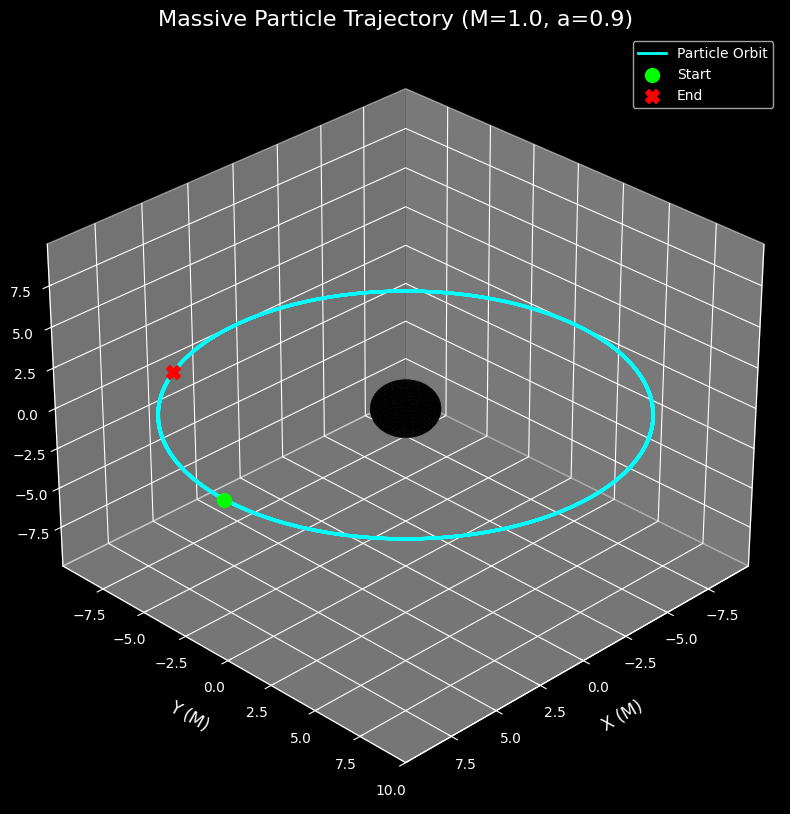

--- Generating Trajectory Component Plots ---
Successfully loaded 5460 data points.


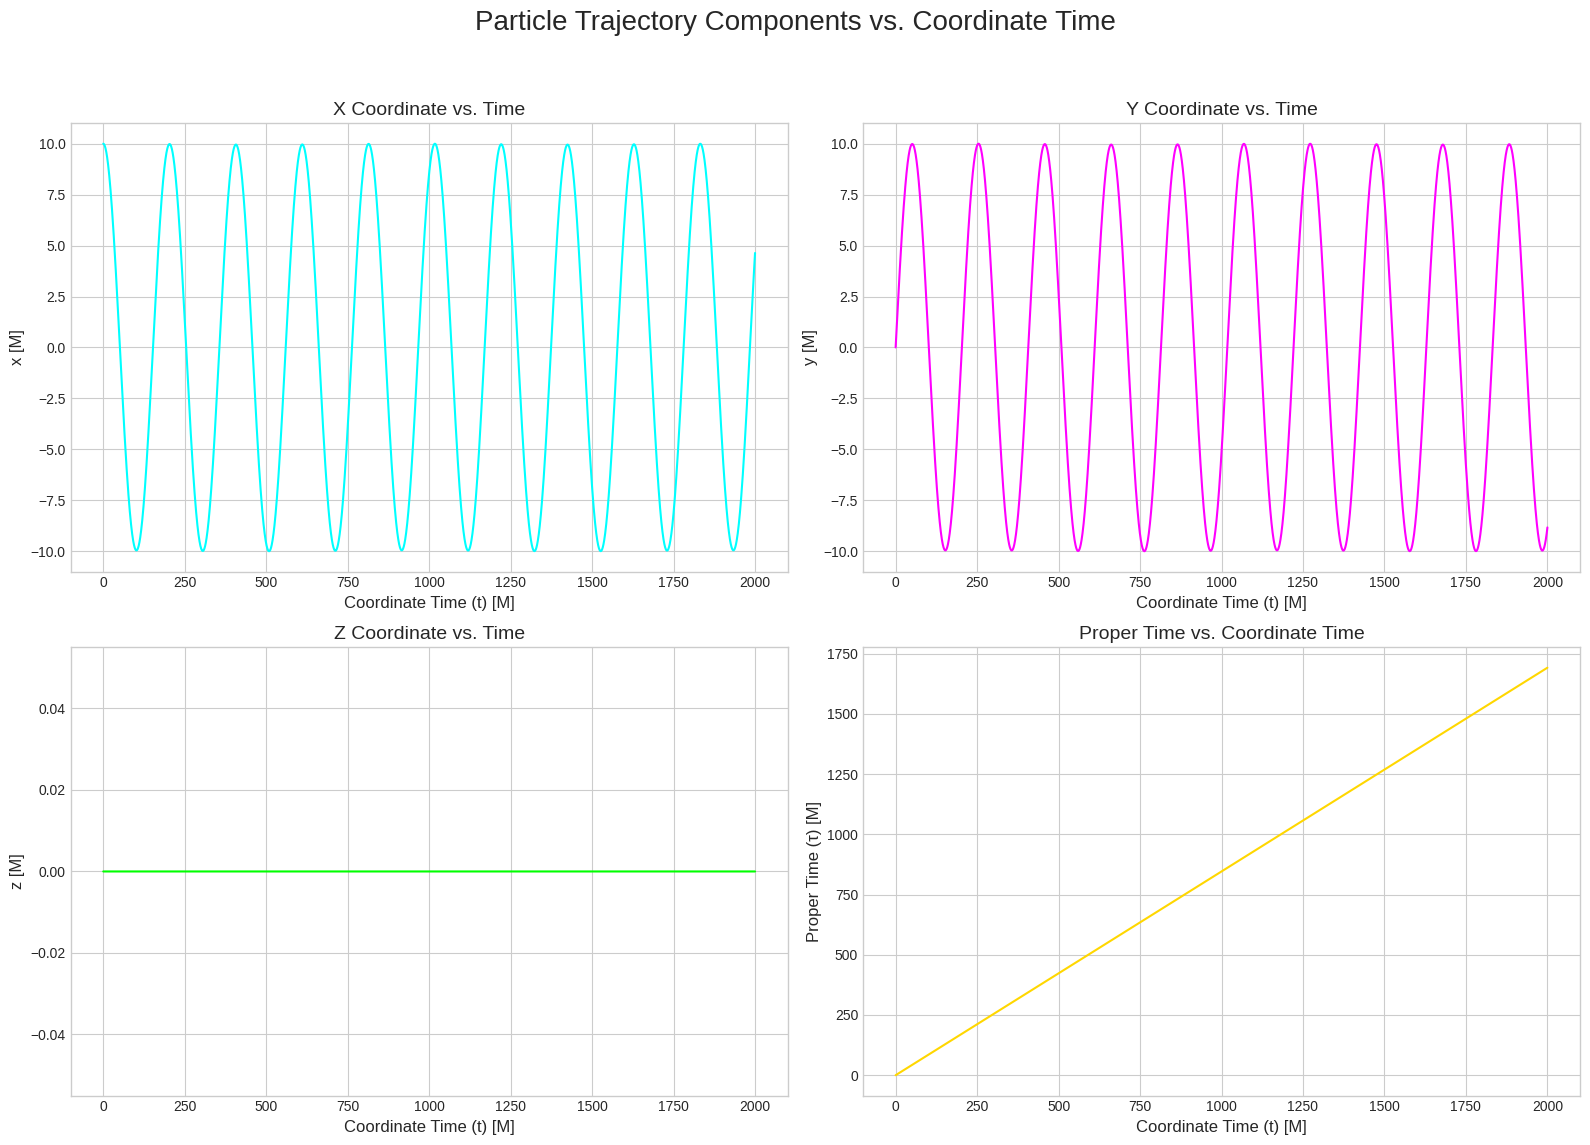

--- Generating Radius vs. Time Validation Plot ---
Radius Statistics:
  Mean Radius: 9.977337 M
  Min Radius:  9.955599 M
  Max Radius:  10.000000 M
  Total Variation: 0.4450%


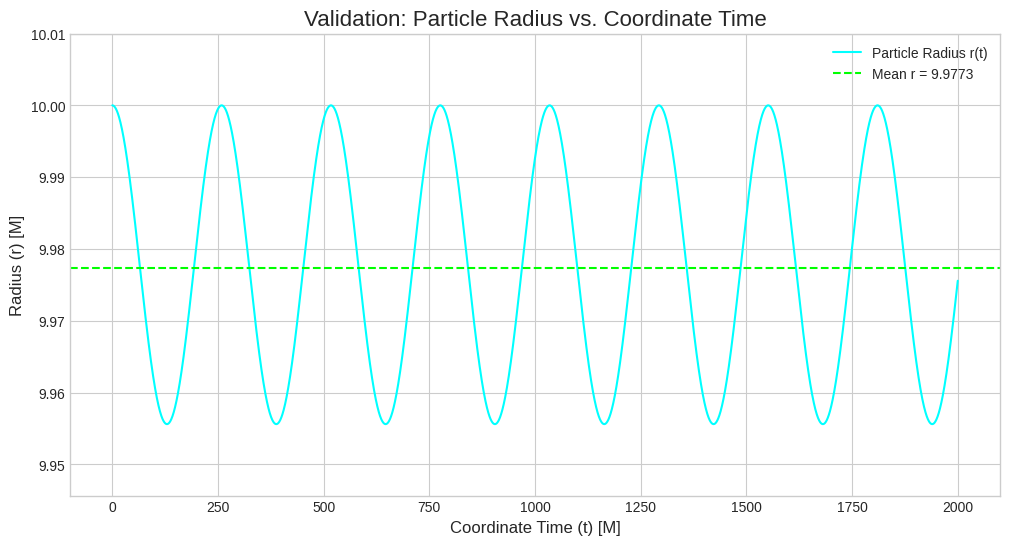

--- Generating Precession Validation Plot ---
Precession Rate (dφ/dt) Validation:
  Theoretical Ω_φ: 0.032548 rad/M
  Measured Ω_φ (from data): 0.030868 rad/M
  Relative Error: 5.1592%


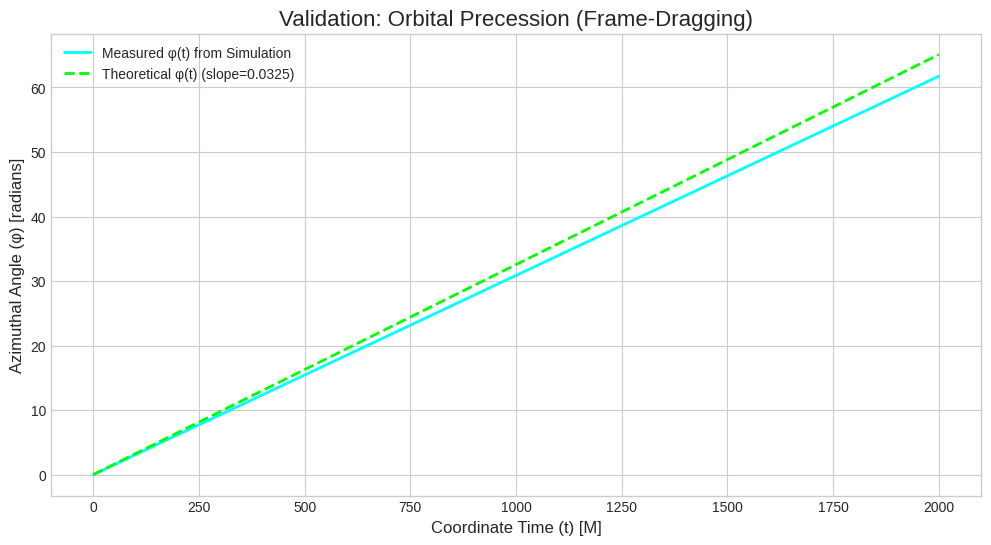

--- Generating Apsidal Precession Validation Plot ---
Apsidal Precession Validation (at average radius r=9.977 M):
  Measured precession per orbit:   -2.288284 radians
  Theoretical precession per orbit: 1.810271 radians
  Relative Error: 226.4056%


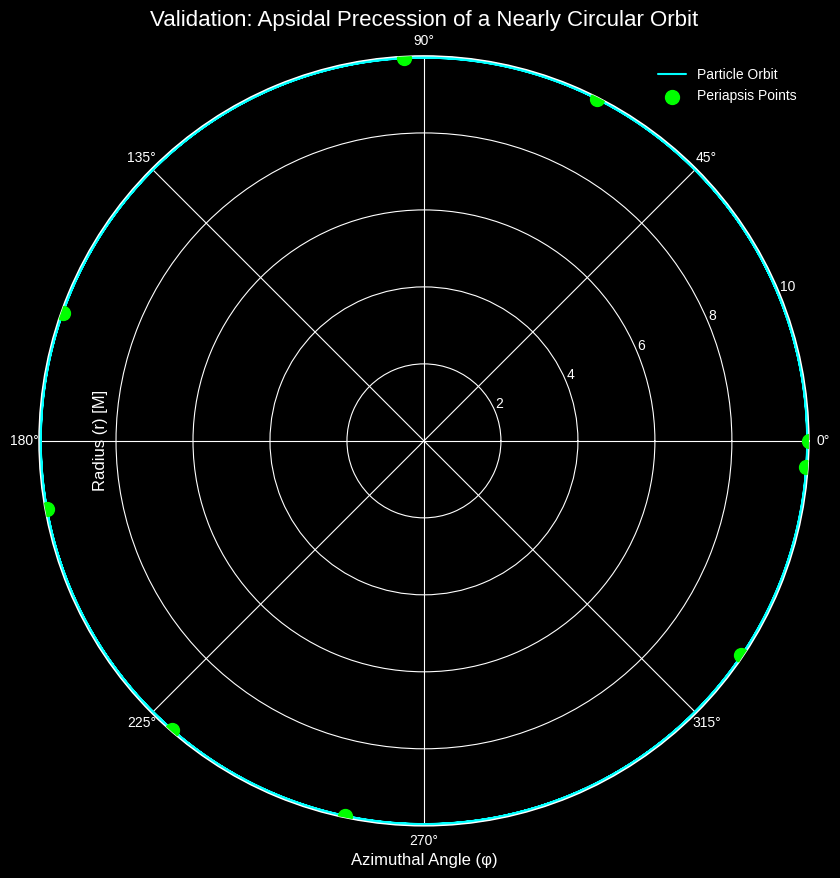

In [53]:
plot_particle_trajectory(
    project_dir="project/mass_integrator",
    input_filename="massive_particle_path.txt",
    M_scale=1.0,
    a_spin=0.9
)
# After running the C code, call this function.
plot_trajectory_components()
# Call this function after running your C code.
plot_radius_vs_time()
# --- How to run ---
plot_precession_validation()
# --- How to run ---
plot_apsidal_precession_validation()

--- Visualizing Mass Blueprint Snapshot ---
Loading snapshot file: 'project/mass_integrator/output/mass_blueprint_t_0200.bin'
Successfully loaded data for 12351 particles.

--- Data Sanity Checks ---
  Particle count: 12351
  Mean radius: 17.480 M (should be between disk_r_min and disk_r_max)
  Mean spatial 4-velocity magnitude: 0.275
  Max z-coordinate: 0.00e+00 (should be close to zero)


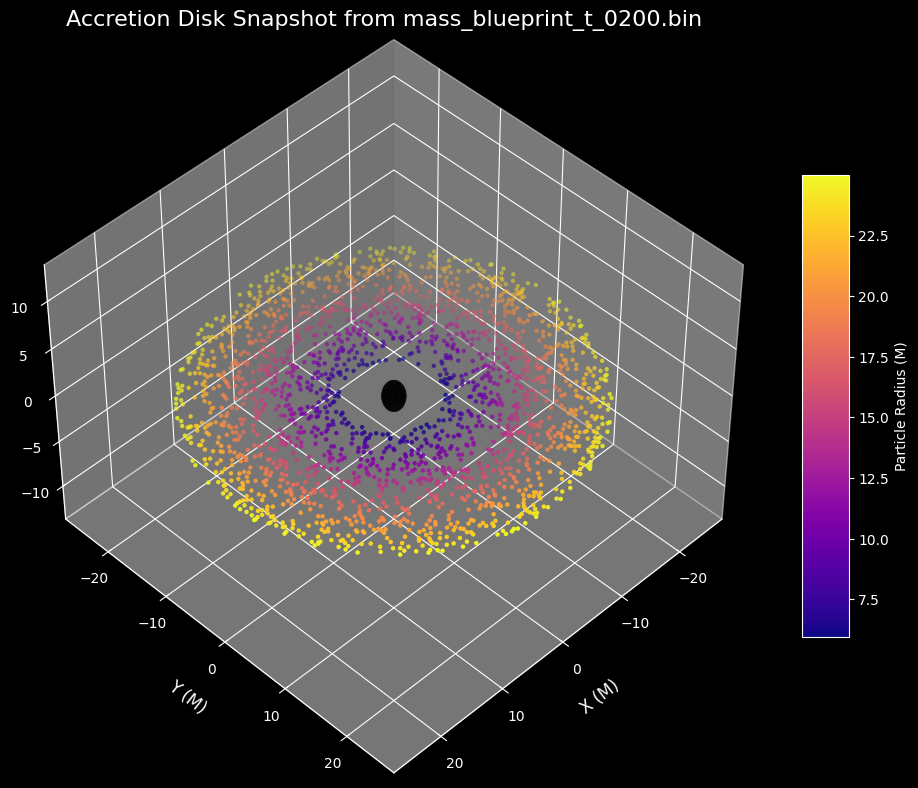

NameError: name 'visualize_disk_and_trajectories' is not defined

In [52]:
# --- How to Run This Test ---
# 1. Run your C code in PRODUCTION mode (set run_in_debug_mode = false in the .par file).
# 2. This will create an 'output' folder with several .bin files.
# 3. Call this function. It will automatically find and plot the LAST snapshot.
visualize_disk_snapshot()
# --- How to Run ---
visualize_disk_and_trajectories()